# OpenClassrooms - Ingenieur IA
# Projet 7 - AirParadis
# Détectez les Bad Buzz grâce au Deep Learning

## Objectif du projet : 
- **Développer le prototype d’un produit IA permettant de prédire le sentiment associé à un tweet**

## Trois approches :
- **Approche 1 : 'API sur étagère' en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment**
- **Approche 2 : 'Modèle sur mesure simple' en utilisant le service Azure Machine Learning Studio**
- **Approche 3 : 'Modèle sur mesure avancé' en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet**

## Plan - Approche 3 : 'Modèle sur mesure avancé' :
- **Préparation des données**
    - Chargement des données
    - Nettoyage des données
    - Identification de la cible
    - Séparation du jeu de données
- **Prétraitement des données textuelles (Pre Processing)**
    - Essai de deux techniques de prétraitement
        - Nettoyage des Tweets avec la librairie 'Preprocessor'
        - Lemmatization des Tweets avec la librairie 'SpaCy'
    - Prétraitement des différents DataFrame
- **Approche Machine Learning classique (modèle de référence)**    
    - Choix de la métrique d'évaluation
    - Représentation des données textuelles : TFIDF
    - Modélisation : Regression logistique
    - Evaluation
- **Approche Deep Learning (modèles avancés)**     
    - Représentation des données textuelles : plongements de mots (Words Embeddings)
        - Modèles GloVe classique préentrainé
    - Modélisation : Réseaux de neurones
        - Création des jeux de données adaptés aux modèles réseaux de neurones
        - Modélisations utilisant différentes architectures
        - Evaluation
        - Sélection du meilleur modèle
        - Optimisation du meilleur modèle
            - Optimisation du plongement de mots
                - Modèle FastText entrainé sur les Tweets du jeu d'entrainement
                - Modèle GloVe préentrainé sur des Tweets
            - Optimisation des hyper paramètres
                - Optimisation des Dropout
                - Optimisation du Learning Rate
            - Choix du meilleur nombre d'epochs
        - Evaluation du meilleur modèle optimisé
        - Sauvegarde du meilleur modèle
        - Prédictions sur le jeu de données 'app' pour comparaison avec les autres approches
        - Analyse des erreurs de prédiction
- **Prototype permettant de prédire le sentiment associé à un tweet**
    - Fonction 'prototype'
    - Test du déploiement dans Azure

In [1]:
import io

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

import gensim.downloader as api

import spacy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, Input, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.text import tokenizer_from_json

from gensim.models import FastText

import preprocessor as tweetpreprocessor

import time
import random as python_random
import warnings
warnings.filterwarnings('ignore')

C:\Users\olivi\anaconda3\envs\env_OC_P7_ok\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nlp = spacy.load("en_core_web_sm")

##### On fixe l'aléatoire pour la reproductibilité des modélisations :

In [3]:
SEED=0
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

# Préparation des données

## Chargement des données

In [4]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)

In [5]:
data.shape

(1600000, 6)

In [6]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Nettoyage des données
- Nous gardons uniquement les colonnes 0 et 5 qui nous seront utiles pour notre étude
- Nous renommons les colonnes 'SENTIMENT' et 'TWEET'

In [7]:
df_tweets = pd.concat([data[0], data[5]], axis=1)

In [8]:
df_tweets = df_tweets.rename(columns={0: "SENTIMENT", 5: "TWEET"})

In [9]:
df_tweets

,SENTIMENT,TWEET
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


##### Le jeu de données nettoyé contient :
- Les Tweets (colonne 'TWEET')
- Le sentiment associé à chaque Tweet (colonne 'SENTIMENT')

## Identification de la cible
- La cible correspond à la colonne 'SENTIMENT'
- Il y a 2 valeurs possibles : 0 et 4
    - La valeur 0 correspond à un sentiment négatif
    - La valeur 4 correspond à un sentiment positif
- Pour plus de clareté, nous allons remplacer la valeur 4 par 1
- Les Tweets sont équirépartis par sentiment

In [10]:
df_tweets["SENTIMENT"].value_counts()

0    800000
4    800000
Name: SENTIMENT, dtype: int64

In [11]:
df_tweets["SENTIMENT"] = df_tweets["SENTIMENT"].replace(4, 1)

In [12]:
df_tweets

,SENTIMENT,TWEET
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [13]:
df_tweets["SENTIMENT"].value_counts()

0    800000
1    800000
Name: SENTIMENT, dtype: int64

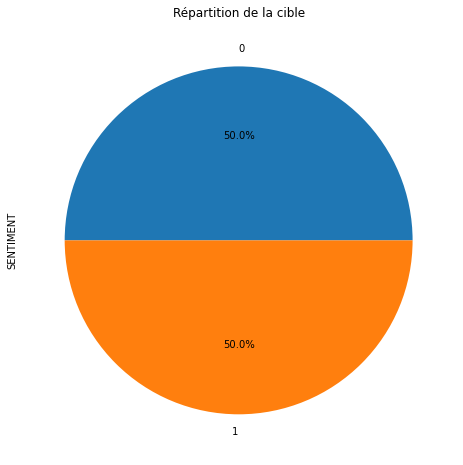

In [14]:
_=df_tweets["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

## Séparation du jeu de données

### Création des jeux de données suivants :
- 'Approach' (app) : utilisé pour comparer les trois approches et sélectionner la meilleure parmi les trois (API sur étagère, modèle simple, modèle avancé)
- 'Validation' (val) : utilisé pour la sélection du meilleur modèle avancé et l'optimisation des hyper paramètres
- 'Train' (train) : utilisé pour entrainer le meilleur modèle et obtenir le modèle qui sera déployé
- 'Train_sample (train_sample)' : échantillon extrait du jeu 'Train' pour entrainer les différents modèles avancés
- 'Test' (test) : utilisé pour l'évaluation finale du meilleur modèle avancé

#### Remarques :
- Les jeux de données sont stratifiés afin de garder la proportion de sentiments positifs et négatifs
- Nous avons été particulièrement attentifs à ne pas toucher le jeu de test afin qu'il n'y ait pas de fuite de données

### Création du DataFrame 'Approach'

In [15]:
APP_SIZE = 2000

In [16]:
df_app, df_tweets = train_test_split(df_tweets, stratify=df_tweets["SENTIMENT"], train_size=APP_SIZE, random_state=SEED)

In [17]:
df_tweets

,SENTIMENT,TWEET
732038,0,@sweetney @herbadmother - Wishing I could wave...
530808,0,Cleaning with a busted elbow translates to: OW...
522863,0,Fish and Chips... Mushy Peas... then work
337896,0,@tommyblom this will be the first time I've no...
517073,0,hey everyone send good vibes for ralph&amp; ma...
...,...,...
1373065,1,"Ohh, there it goes"
752643,0,@Aroundtheus haha cause I am always working I...
818028,1,@tdfangirl YAY ! That's so exciting!
318481,0,disappointed not to be kayaking tonight with t...


In [18]:
df_tweets = df_tweets.reset_index(drop=True)

In [19]:
df_tweets

,SENTIMENT,TWEET
0,0,@sweetney @herbadmother - Wishing I could wave...
1,0,Cleaning with a busted elbow translates to: OW...
2,0,Fish and Chips... Mushy Peas... then work
3,0,@tommyblom this will be the first time I've no...
4,0,hey everyone send good vibes for ralph&amp; ma...
...,...,...
1597995,1,"Ohh, there it goes"
1597996,0,@Aroundtheus haha cause I am always working I...
1597997,1,@tdfangirl YAY ! That's so exciting!
1597998,0,disappointed not to be kayaking tonight with t...


In [20]:
df_tweets["SENTIMENT"].value_counts()

0    799000
1    799000
Name: SENTIMENT, dtype: int64

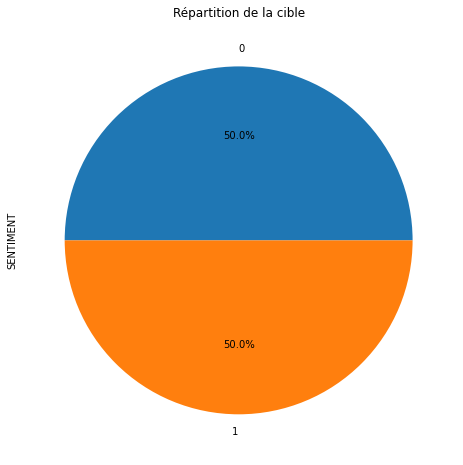

In [21]:
_=df_tweets["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

In [22]:
df_app = df_app.reset_index(drop=True)

In [23]:
df_app

,SENTIMENT,TWEET
0,1,Pictures!!
1,1,just watched One Tree Hill episode 22 season 6...
2,1,and so the micro blogging begins!!
3,1,awesooome. i found me some chickeeen waaangs t...
4,0,Please don't go.
...,...,...
1995,1,Rain wont stop.... bring on the munchies and t...
1996,1,@citylivinggirl Thank you
1997,1,tonight was fun
1998,0,Back from #phish. The only downer was leaving ...


#### Taille du jeu 'Approach'

In [24]:
len(df_app["SENTIMENT"])

2000

#### Répartition du jeu 'Approach'

In [25]:
df_app["SENTIMENT"].value_counts()

0    1000
1    1000
Name: SENTIMENT, dtype: int64

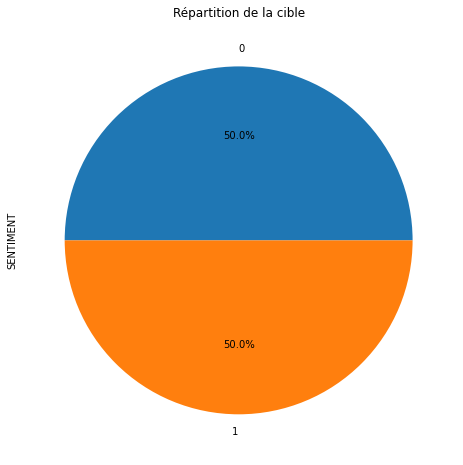

In [26]:
_=df_app["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

### Création du DataFrame 'Validation'

In [27]:
VAL_SIZE = 50000

In [28]:
df_val, df_tweets = train_test_split(df_tweets, stratify=df_tweets["SENTIMENT"], train_size=VAL_SIZE, random_state=SEED)

In [29]:
df_tweets = df_tweets.reset_index(drop=True)

In [30]:
df_tweets

,SENTIMENT,TWEET
0,0,Have to get up early for school tomorrow too...
1,0,@the_zac_efron I was online yesterday right at...
2,1,Raining.
3,1,@crustyjuggler72 just please - DO NOT post as ...
4,1,@point_moot You're welcome! scotch_mist was th...
...,...,...
1547995,0,having difficulty walking today...no time for ...
1547996,0,@tiffani_m im sypathetic...
1547997,1,Ne~ (-: Baseemah
1547998,0,@andrewlighten pity they haven't upgraded the ...


In [31]:
df_tweets["SENTIMENT"].value_counts()

0    774000
1    774000
Name: SENTIMENT, dtype: int64

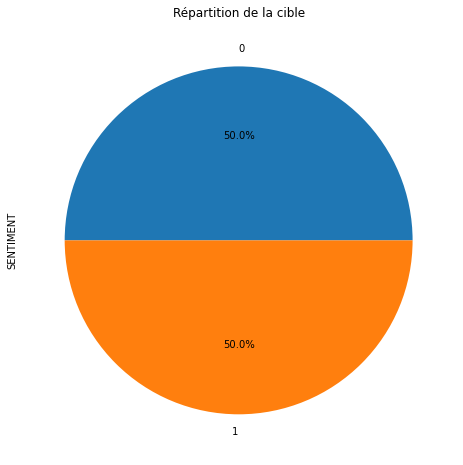

In [32]:
_=df_tweets["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

In [33]:
df_val = df_val.reset_index(drop=True)

In [34]:
df_val

,SENTIMENT,TWEET
0,0,@jacquelinos ... i cant understand your twwwwe...
1,0,What's the point of an election when none of t...
2,1,Lovely new pieces @blissdesigns Casual &amp; e...
3,0,Uuuggghhhh... Can't fall asleep
4,1,@onejan84 thanks for the follow friday rockin...
...,...,...
49995,0,@nboogz well ya ari is the shit! I miss her. ...
49996,1,@Lovelyjanay hey girl! thanks for the add
49997,1,@tiinag Thank you
49998,1,You can't help who you love


#### Taille du jeu 'Validation'

In [35]:
len(df_val["SENTIMENT"])

50000

#### Répartition du jeu 'Validation'

In [36]:
df_val["SENTIMENT"].value_counts()

0    25000
1    25000
Name: SENTIMENT, dtype: int64

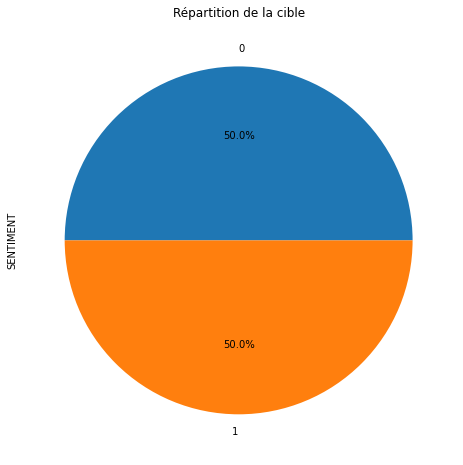

In [37]:
_=df_val["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

### Création des DataFrame 'Train' et 'Test'

In [38]:
df_train, df_test = train_test_split(df_tweets, stratify=df_tweets["SENTIMENT"], train_size=0.8, random_state=SEED)

In [39]:
df_train = df_train.reset_index(drop=True)

In [40]:
df_train

,SENTIMENT,TWEET
0,0,@oconel *grins* Am wearing new shirt and manag...
1,1,Did my second senior project... Now watching s...
2,1,@feedmydisaster noo... well... facebook... fri...
3,1,"blah , a light bulb in my room is broke and no..."
4,0,@lakikix yea I wish I was there too Nite nite...
...,...,...
1238395,0,"I'm just not able to be in USA for a month, wi..."
1238396,0,@16StarGirl16 why are you sad bby?
1238397,1,Nap time's the best time.
1238398,0,@sangitashres ok.. i need to by it then


#### Taille du jeu 'Train'

In [41]:
len(df_train["SENTIMENT"])

1238400

#### Répartition du jeu 'Train'

In [42]:
df_train["SENTIMENT"].value_counts()

0    619200
1    619200
Name: SENTIMENT, dtype: int64

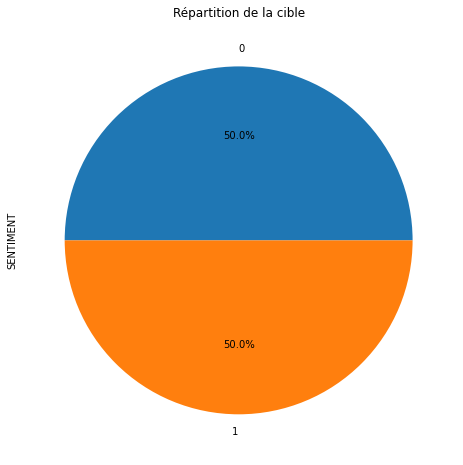

In [43]:
_=df_train["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

In [44]:
df_test = df_test.reset_index(drop=True)

In [45]:
df_test

,SENTIMENT,TWEET
0,0,@myria101 Ew. She could've at least been fortu...
1,1,My dignity is intact ......... now if i'd spen...
2,0,@darrkwillow sayid could be dead.
3,1,I'm selling these Brand New Scholl Wooden Leat...
4,0,says A relative just died today http://plurk....
...,...,...
309595,0,How could i let myself believe that something ...
309596,1,And i am done! No thanks to someone. Who knew...
309597,0,Bad cramps day again.
309598,0,Current gripe: never being full


#### Taille du jeu 'Test'

In [46]:
len(df_test["SENTIMENT"])

309600

#### Répartition du jeu 'Test'

In [47]:
df_test["SENTIMENT"].value_counts()

0    154800
1    154800
Name: SENTIMENT, dtype: int64

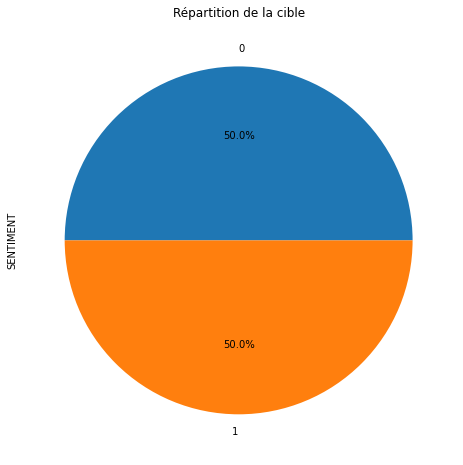

In [48]:
_=df_test["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

### Création du DataFrame 'Train_sample'

In [49]:
SAMPLE_SIZE = 50000

In [50]:
df_train_sample, _ = train_test_split(df_train, stratify=df_train["SENTIMENT"], train_size=SAMPLE_SIZE, random_state=SEED)

In [51]:
df_train_sample = df_train_sample.reset_index(drop=True)

In [52]:
df_train_sample

,SENTIMENT,TWEET
0,0,i dont want my mama to go
1,1,Out in the city on my way to the nail salon a...
2,0,never will take open office from sources . to...
3,0,just watched the first released scene of New M...
4,1,Morning off! Got to go back to school at 1.30 ...
...,...,...
49995,1,@HeidiLeAnn thanks when do you return?
49996,0,didn't win anything but we saw REALLY good ba...
49997,1,@christinelu Thanks for passing on the listing...
49998,1,@lukeeeeee24 - you need to get a new phone then


#### Taille du jeu 'Train_sample'

In [53]:
len(df_train_sample["SENTIMENT"])

50000

#### Répartition du jeu 'Train_sample'

In [54]:
df_train_sample["SENTIMENT"].value_counts()

0    25000
1    25000
Name: SENTIMENT, dtype: int64

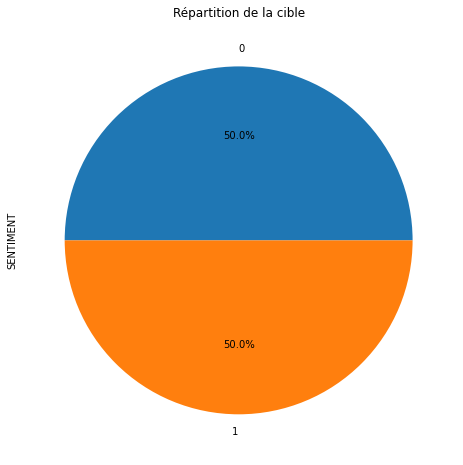

In [55]:
_=df_train_sample["SENTIMENT"].value_counts().plot(kind='pie',figsize=(10,8),autopct='%1.1f%%',title="Répartition de la cible")

# Prétraitement des données textuelles (PreProcessing)
- Nous avons mis en place deux techniques de prétraitement :
    - Nettoyage des Tweets avec la librairie 'Preprocessor'
    - Lemmatization des Tweets avec la librairie 'SpaCy'

## Nettoyage des Tweets avec la librairie 'Preprocessor'
- Cette librairie Python est spécialisée dans le prétraitement des Tweets
- Celle-ci permet de nettoyer les Tweets finement : on peut supprimer les éléments superflus des Tweets selon le besoin
- Nous avons essayé deux types de nettoyage :
    - Nettoyage 'complet' : consiste à enlever tous les éléments superflus
    - Nettoyage 'léger' : consiste à enlever uniquement les éléments de type URL et EMOJI

### PreProcessing 'Complet'

#### Exemple

In [56]:
tweetpreprocessor.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

'Preprocessor is'

#### PreProcessing DataFrame 'Train'

In [57]:
df_train['TWEET_PREPROCESSED'] = df_train['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [58]:
df_train

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,0,@oconel *grins* Am wearing new shirt and manag...,*grins* Am wearing new shirt and managed to ge...
1,1,Did my second senior project... Now watching s...,Did my second senior project... Now watching s...
2,1,@feedmydisaster noo... well... facebook... fri...,noo... well... facebook... friends... postmate...
3,1,"blah , a light bulb in my room is broke and no...","blah , a light bulb in my room is broke and no..."
4,0,@lakikix yea I wish I was there too Nite nite...,yea I wish I was there too Nite nite kiki
...,...,...,...
1238395,0,"I'm just not able to be in USA for a month, wi...","I'm just not able to be in USA for a month, wi..."
1238396,0,@16StarGirl16 why are you sad bby?,why are you sad bby?
1238397,1,Nap time's the best time.,Nap time's the best time.
1238398,0,@sangitashres ok.. i need to by it then,ok.. i need to by it then


In [59]:
X_train = df_train["TWEET_PREPROCESSED"].values
y_train = df_train["SENTIMENT"].values

In [60]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (1238400,)
y_train Shape: (1238400,)


In [61]:
X_train

array(["*grins* Am wearing new shirt and managed to get stain on it right away *sad* It's not a big one, but I know it's there",
       'Did my second senior project... Now watching some obsessed',
       'noo... well... facebook... friends... postmater??... hi5... stumbleupon.... and greenpeace',
       ..., "Nap time's the best time.", 'ok.. i need to by it then',
       'talking on the phone with baby v &amp; kevinngoo'], dtype=object)

In [62]:
y_train

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

#### Sauvegarde du DataFrame 'Train'

In [63]:
df_train.to_csv("airparadis_train_dataset.csv", index=False)

#### PreProcessing DataFrame 'Train_sample'

In [64]:
df_train_sample['TWEET_PREPROCESSED'] = df_train_sample['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [65]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,0,i dont want my mama to go,i dont want my mama to go
1,1,Out in the city on my way to the nail salon a...,Out in the city on my way to the nail salon an...
2,0,never will take open office from sources . to...,never will take open office from sources . tot...
3,0,just watched the first released scene of New M...,just watched the first released scene of New M...
4,1,Morning off! Got to go back to school at 1.30 ...,"Morning off! Got to go back to school at so, s..."
...,...,...,...
49995,1,@HeidiLeAnn thanks when do you return?,thanks when do you return?
49996,0,didn't win anything but we saw REALLY good ba...,didn't win anything but we saw REALLY good ban...
49997,1,@christinelu Thanks for passing on the listing...,Thanks for passing on the listing! I'm excited...
49998,1,@lukeeeeee24 - you need to get a new phone then,- you need to get a new phone then


In [66]:
X_train_sample = df_train_sample["TWEET_PREPROCESSED"].values
y_train_sample = df_train_sample["SENTIMENT"].values

In [67]:
print("X_train_sample Shape:", X_train_sample.shape)
print("y_train_sample Shape:", y_train_sample.shape)

X_train_sample Shape: (50000,)
y_train_sample Shape: (50000,)


In [68]:
X_train_sample

array(['i dont want my mama to go',
       'Out in the city on my way to the nail salon and Jamba Juice',
       'never will take open office from sources . total compile time hrs min.',
       ..., "Thanks for passing on the listing! I'm excited about",
       '- you need to get a new phone then',
       'ugh why not? Billy ray says he does but he never does to me'],
      dtype=object)

In [69]:
y_train_sample

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

##### X_train_sample_notpreprocessed : version avec tweets non pré processés pour comparaison des résulats

In [70]:
X_train_sample_notpreprocessed = df_train_sample["TWEET"].values

#### PreProcessing DataFrame 'Test'

In [71]:
df_test['TWEET_PREPROCESSED'] = df_test['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [72]:
df_test

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,0,@myria101 Ew. She could've at least been fortu...,Ew. She could've at least been fortunate-looki...
1,1,My dignity is intact ......... now if i'd spen...,My dignity is intact ......... now if i'd spen...
2,0,@darrkwillow sayid could be dead.,sayid could be dead.
3,1,I'm selling these Brand New Scholl Wooden Leat...,I'm selling these Brand New Scholl Wooden Leat...
4,0,says A relative just died today http://plurk....,says A relative just died today
...,...,...,...
309595,0,How could i let myself believe that something ...,How could i let myself believe that something ...
309596,1,And i am done! No thanks to someone. Who knew...,And i am done! No thanks to someone. Who knew ...
309597,0,Bad cramps day again.,Bad cramps day again.
309598,0,Current gripe: never being full,Current gripe: never being full


In [73]:
X_test = df_test["TWEET_PREPROCESSED"].values
y_test = df_test["SENTIMENT"].values

In [74]:
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (309600,)
y_test Shape: (309600,)


In [75]:
X_test

array(["Ew. She could've at least been fortunate-looking. Poor you. She fails.",
       "My dignity is intact ......... now if i'd spent weeks on a film with him it would've been a different story",
       'sayid could be dead.', ..., 'Bad cramps day again.',
       'Current gripe: never being full', 'I wish the rain would stop'],
      dtype=object)

In [76]:
y_test

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

#### PreProcessing DataFrame 'Validation'

In [77]:
df_val['TWEET_PREPROCESSED'] = df_val['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [78]:
df_val

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,0,@jacquelinos ... i cant understand your twwwwe...,... i cant understand your twwwweeeets.
1,0,What's the point of an election when none of t...,What's the point of an election when none of t...
2,1,Lovely new pieces @blissdesigns Casual &amp; e...,Lovely new pieces Casual &amp; elegant!
3,0,Uuuggghhhh... Can't fall asleep,Uuuggghhhh... Can't fall asleep
4,1,@onejan84 thanks for the follow friday rockin...,thanks for the follow friday rockin as always
...,...,...,...
49995,0,@nboogz well ya ari is the shit! I miss her. ...,well ya ari is the shit! I miss her. And u..
49996,1,@Lovelyjanay hey girl! thanks for the add,hey girl! thanks for the add
49997,1,@tiinag Thank you,Thank you
49998,1,You can't help who you love,You can't help who you love


In [79]:
X_val = df_val["TWEET_PREPROCESSED"].values
y_val = df_val["SENTIMENT"].values

In [80]:
print("X_val Shape:", X_val.shape)
print("y_val Shape:", y_val.shape)

X_val Shape: (50000,)
y_val Shape: (50000,)


In [81]:
X_val

array(['... i cant understand your twwwweeeets.',
       "What's the point of an election when none of the votes matter?",
       'Lovely new pieces Casual &amp; elegant!', ..., 'Thank you',
       "You can't help who you love",
       'ok..sleep calls upon me, my darkened mother with soft lullaby of dreams..under her black wings I fall..be back tonight'],
      dtype=object)

In [82]:
y_val

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

##### X_val_notpreprocessed : version avec tweets non pré processés pour comparaison des résulats

In [83]:
X_val_notpreprocessed = df_val["TWEET"].values

#### PreProcessing DataFrame 'Approach'

In [84]:
df_app['TWEET_PREPROCESSED'] = df_app['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [85]:
df_app

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,1,Pictures!!,Pictures!!
1,1,just watched One Tree Hill episode 22 season 6...,just watched One Tree Hill episode season ... ...
2,1,and so the micro blogging begins!!,and so the micro blogging begins!!
3,1,awesooome. i found me some chickeeen waaangs t...,awesooome. i found me some chickeeen waaangs t...
4,0,Please don't go.,Please don't go.
...,...,...,...
1995,1,Rain wont stop.... bring on the munchies and t...,Rain wont stop.... bring on the munchies and t...
1996,1,@citylivinggirl Thank you,Thank you
1997,1,tonight was fun,tonight was fun
1998,0,Back from #phish. The only downer was leaving ...,Back from . The only downer was leaving and se...


In [86]:
X_app = df_app["TWEET_PREPROCESSED"].values
y_app = df_app["SENTIMENT"].values

In [87]:
print("X_app Shape:", X_app.shape)
print("y_app Shape:", y_app.shape)

X_app Shape: (2000,)
y_app Shape: (2000,)


In [88]:
X_app

array(['Pictures!!',
       'just watched One Tree Hill episode season ... never cried this much since keith died!!!!!! OTH is epic for sure!!!!!! Xxx',
       'and so the micro blogging begins!!', ..., 'tonight was fun',
       'Back from . The only downer was leaving and seeing hundreds and hundreds of people sucking down balloons.',
       "Good afternoon!!!! Twitteralley!!! Working hard today. Hadn't had enough time to visit the past days."],
      dtype=object)

In [89]:
y_app

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

#### Sauvegarde du DataFrame 'Approach'

In [90]:
df_app.to_csv("airparadis_app_dataset.csv", index=False)

### PreProcessing 'Léger'

In [91]:
tweetpreprocessor.set_options(tweetpreprocessor.OPT.URL, tweetpreprocessor.OPT.EMOJI)

In [92]:
tweetpreprocessor.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor')

'Preprocessor is #awesome'

In [93]:
df_train_sample['TWEET_LIGHT_PREPROCESSED'] = df_train_sample['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [94]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED
0,0,i dont want my mama to go,i dont want my mama to go,i dont want my mama to go
1,1,Out in the city on my way to the nail salon a...,Out in the city on my way to the nail salon an...,Out in the city on my way to the nail salon an...
2,0,never will take open office from sources . to...,never will take open office from sources . tot...,never will take open office from sources . tot...
3,0,just watched the first released scene of New M...,just watched the first released scene of New M...,just watched the first released scene of New M...
4,1,Morning off! Got to go back to school at 1.30 ...,"Morning off! Got to go back to school at so, s...",Morning off! Got to go back to school at 1.30 ...
...,...,...,...,...
49995,1,@HeidiLeAnn thanks when do you return?,thanks when do you return?,@HeidiLeAnn thanks when do you return?
49996,0,didn't win anything but we saw REALLY good ba...,didn't win anything but we saw REALLY good ban...,didn't win anything but we saw REALLY good ban...
49997,1,@christinelu Thanks for passing on the listing...,Thanks for passing on the listing! I'm excited...,@christinelu Thanks for passing on the listing...
49998,1,@lukeeeeee24 - you need to get a new phone then,- you need to get a new phone then,@lukeeeeee24 - you need to get a new phone then


In [95]:
X_train_sample_lightpreprocessed = df_train_sample["TWEET_LIGHT_PREPROCESSED"].values

In [96]:
df_val['TWEET_LIGHT_PREPROCESSED'] = df_val['TWEET'].apply(lambda text : tweetpreprocessor.clean(text))

In [97]:
df_val

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED
0,0,@jacquelinos ... i cant understand your twwwwe...,... i cant understand your twwwweeeets.,@jacquelinos ... i cant understand your twwwwe...
1,0,What's the point of an election when none of t...,What's the point of an election when none of t...,What's the point of an election when none of t...
2,1,Lovely new pieces @blissdesigns Casual &amp; e...,Lovely new pieces Casual &amp; elegant!,Lovely new pieces @blissdesigns Casual &amp; e...
3,0,Uuuggghhhh... Can't fall asleep,Uuuggghhhh... Can't fall asleep,Uuuggghhhh... Can't fall asleep
4,1,@onejan84 thanks for the follow friday rockin...,thanks for the follow friday rockin as always,@onejan84 thanks for the follow friday rockin ...
...,...,...,...,...
49995,0,@nboogz well ya ari is the shit! I miss her. ...,well ya ari is the shit! I miss her. And u..,@nboogz well ya ari is the shit! I miss her. A...
49996,1,@Lovelyjanay hey girl! thanks for the add,hey girl! thanks for the add,@Lovelyjanay hey girl! thanks for the add
49997,1,@tiinag Thank you,Thank you,@tiinag Thank you
49998,1,You can't help who you love,You can't help who you love,You can't help who you love


In [98]:
X_val_lightpreprocessed = df_val["TWEET_LIGHT_PREPROCESSED"].values

### Lemmatization des Tweets avec la librairie 'SpaCy'

In [99]:
def lemmatization(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [100]:
df_train_sample['TWEET_LEMMATIZED'] = df_train_sample['TWEET_PREPROCESSED'].apply(lambda text : lemmatization(text))

In [101]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED,TWEET_LEMMATIZED
0,0,i dont want my mama to go,i dont want my mama to go,i dont want my mama to go,I do nt want my mama to go
1,1,Out in the city on my way to the nail salon a...,Out in the city on my way to the nail salon an...,Out in the city on my way to the nail salon an...,out in the city on my way to the nail salon an...
2,0,never will take open office from sources . to...,never will take open office from sources . tot...,never will take open office from sources . tot...,never will take open office from source . tota...
3,0,just watched the first released scene of New M...,just watched the first released scene of New M...,just watched the first released scene of New M...,just watch the first release scene of New Moon...
4,1,Morning off! Got to go back to school at 1.30 ...,"Morning off! Got to go back to school at so, s...",Morning off! Got to go back to school at 1.30 ...,"morning off ! got to go back to school at so ,..."
...,...,...,...,...,...
49995,1,@HeidiLeAnn thanks when do you return?,thanks when do you return?,@HeidiLeAnn thanks when do you return?,thank when do you return ?
49996,0,didn't win anything but we saw REALLY good ba...,didn't win anything but we saw REALLY good ban...,didn't win anything but we saw REALLY good ban...,do n't win anything but we see REALLY good ban...
49997,1,@christinelu Thanks for passing on the listing...,Thanks for passing on the listing! I'm excited...,@christinelu Thanks for passing on the listing...,thank for pass on the listing ! I be excited a...
49998,1,@lukeeeeee24 - you need to get a new phone then,- you need to get a new phone then,@lukeeeeee24 - you need to get a new phone then,- you need to get a new phone then


In [102]:
X_train_sample_lemma = df_train_sample["TWEET_LEMMATIZED"].values

In [103]:
X_train_sample_lemma

array(['I do nt want my mama to go',
       'out in the city on my way to the nail salon and Jamba Juice',
       'never will take open office from source . total compile time hrs min .',
       ..., 'thank for pass on the listing ! I be excited about',
       '- you need to get a new phone then',
       'ugh why not ? Billy ray say he do but he never do to I'],
      dtype=object)

In [104]:
df_val['TWEET_LEMMATIZED'] = df_val['TWEET_PREPROCESSED'].apply(lambda text : lemmatization(text))

In [105]:
X_val_lemma = df_val["TWEET_LEMMATIZED"].values

In [106]:
X_val_lemma

array(['... I ca nt understand your twwwweeeet .',
       'what be the point of an election when none of the vote matter ?',
       'lovely new piece Casual & amp ; elegant !', ..., 'thank you',
       "you ca n't help who you love",
       'ok .. sleep call upon I , my darken mother with soft lullaby of dream .. under her black wing I fall .. be back tonight'],
      dtype=object)

### Fonction de suppression manuelles des : hashtags, @ and url
##### Remarque :
- On peut également effectuer un préprocessing 'manuel' des tweets grâce à la fonction ci-dessous qui permet de supprimer les élements liés à la liste 'character_list'

In [107]:
def remove_word_with_chararcter(text, character_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    result = [element for element in text if all(character not in element for character in character_list)]
    text_cleaned = ' '.join(result)
    return text_cleaned

In [108]:
character_list = ['@', '#', 'http', 'www', '/']

# Approche Machine Learning classique (modèle de référence)
- Cette approche va nous permettre de mettre en place un modèle basique de référence qui nous servira de comparaison pour évaluer la performance des modèles plus complexes basés sur l'approche Deep Learning (Réseaux de neurones)

## Choix de la métrique d'évaluation
- Nous avons choisi la métrique **Accuracy**, car : 
    - Les données sont équlibrées
    - Il faut déterminer les sentiments corrects à égalité, qu'ils soient positifs ou négatifs

## Modélisation sur les Tweets nettoyés mais non lemmatisés

### Représentation des données textuelles : TFIDF

In [109]:
tfidf_model = TfidfVectorizer()

In [110]:
tfidf_skl = tfidf_model.fit_transform(X_train_sample)

In [111]:
tfidf_skl

<50000x34525 sparse matrix of type '<class 'numpy.float64'>'
	with 554643 stored elements in Compressed Sparse Row format>

#### Taille du vocabulaire

In [112]:
len(tfidf_model.vocabulary_)

34525

#### Vocabulaire

In [113]:
tfidf_model.vocabulary_

{'dont': 8590,
 'want': 32743,
 'my': 19934,
 'mama': 18206,
 'to': 30452,
 'go': 12266,
 'out': 21529,
 'in': 14787,
 'the': 29981,
 'city': 5749,
 'on': 21220,
 'way': 32879,
 'nail': 20027,
 'salon': 25820,
 'and': 1348,
 'jamba': 15477,
 'juice': 15901,
 'never': 20351,
 'will': 33407,
 'take': 29458,
 'open': 21320,
 'office': 21036,
 'from': 11480,
 'sources': 27934,
 'total': 30703,
 'compile': 6271,
 'time': 30315,
 'hrs': 14250,
 'min': 19090,
 'just': 15961,
 'watched': 32825,
 'first': 10835,
 'released': 24767,
 'scene': 26073,
 'of': 21019,
 'new': 20361,
 'moon': 19514,
 'too': 30610,
 'bad': 2440,
 'it': 15340,
 'is': 15285,
 'only': 21243,
 'seconds': 26274,
 'morning': 19558,
 'off': 21022,
 'got': 12458,
 'back': 2389,
 'school': 26098,
 'at': 2005,
 'so': 27651,
 'all': 1074,
 'gooood': 12406,
 'hehe': 13540,
 'meanwhile': 18657,
 'still': 28542,
 'trying': 31062,
 'find': 10764,
 'prom': 23498,
 'shoes': 26828,
 'ook': 21281,
 'im': 14690,
 'goign': 12315,
 'watch':

### Modélisation : Regression logistique

In [114]:
log_reg_model = LogisticRegression(random_state=SEED)

In [115]:
log_tfidf_model = Pipeline([('vect', tfidf_model),
                              ('clf', log_reg_model)])

In [116]:
log_tfidf_model.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=0))])

### Evaluation

#### Accuracy score :

In [117]:
log_tfidf_model_accuracy = log_tfidf_model.score(X_val, y_val)

In [118]:
print(f"Accuracy score = {log_tfidf_model_accuracy:.3f}")

Accuracy score = 0.776


#### Prédictions :

In [119]:
predicted_labels = log_tfidf_model.predict(X_val)
predicted_labels

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

#### Matrice de confusion :

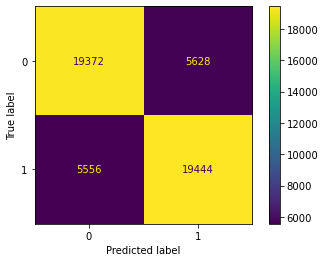

In [120]:
cm = confusion_matrix(y_val, predicted_labels)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

#### Rapport de classifiction :

In [121]:
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78     25000
           1       0.78      0.78      0.78     25000

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000



## Modélisation sur les Tweets nettoyés et lemmatisés

### Représentation des données textuelles : TFIDF

In [122]:
tfidf_lemma_model = TfidfVectorizer()

In [123]:
tfidf_lemma_skl = tfidf_lemma_model.fit_transform(X_train_sample_lemma)

In [124]:
tfidf_lemma_skl

<50000x30798 sparse matrix of type '<class 'numpy.float64'>'
	with 550300 stored elements in Compressed Sparse Row format>

#### Taille du vocabulaire

In [125]:
len(tfidf_lemma_model.vocabulary_)

30798

#### Vocabulaire

In [126]:
tfidf_lemma_model.vocabulary_

{'do': 7498,
 'nt': 18700,
 'want': 29177,
 'my': 17894,
 'mama': 16317,
 'to': 27084,
 'go': 10850,
 'out': 19372,
 'in': 13159,
 'the': 26662,
 'city': 5160,
 'on': 19086,
 'way': 29288,
 'nail': 17984,
 'salon': 23066,
 'and': 1247,
 'jamba': 13775,
 'juice': 14185,
 'never': 18284,
 'will': 29764,
 'take': 26190,
 'open': 19186,
 'office': 18913,
 'from': 10126,
 'source': 24892,
 'total': 27312,
 'compile': 5597,
 'time': 26956,
 'hrs': 12668,
 'min': 17120,
 'just': 14239,
 'watch': 29240,
 'first': 9582,
 'release': 22173,
 'scene': 23293,
 'of': 18900,
 'new': 18295,
 'moon': 17513,
 'too': 27226,
 'bad': 2227,
 'it': 13646,
 'be': 2570,
 'only': 19108,
 'second': 23459,
 'morning': 17554,
 'off': 18903,
 'got': 11035,
 'back': 2182,
 'school': 23314,
 'at': 1833,
 'so': 24636,
 'all': 988,
 'gooood': 10984,
 'hehe': 12004,
 'meanwhile': 16731,
 'still': 25412,
 'try': 27603,
 'find': 9520,
 'prom': 21071,
 'shoe': 23941,
 'ook': 19146,
 'goign': 10898,
 'he': 11884,
 'not': 18

### Modélisation : Regression logistique

In [127]:
log_reg_lemma_model = LogisticRegression(random_state=SEED)

In [128]:
log_tfidf_lemma_model = Pipeline([('vect', tfidf_lemma_model),
                                  ('clf', log_reg_lemma_model)])

In [129]:
log_tfidf_lemma_model.fit(X_train_sample_lemma, y_train_sample)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=0))])

### Evaluation

#### Accuracy score :

In [130]:
log_tfidf_lemma_model_accuracy = log_tfidf_lemma_model.score(X_val_lemma, y_val)

In [131]:
print(f"Accuracy score = {log_tfidf_lemma_model_accuracy:.3f}")

Accuracy score = 0.772


#### Prédictions :

In [132]:
predicted_labels_lemma = log_tfidf_lemma_model.predict(X_val_lemma)
predicted_labels_lemma

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

#### Matrice de confusion :

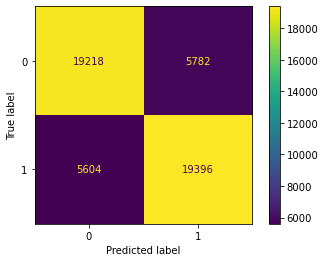

In [133]:
cm = confusion_matrix(y_val, predicted_labels_lemma)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

#### Rapport de classifiction :

In [134]:
print(classification_report(y_val, predicted_labels_lemma))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     25000
           1       0.77      0.78      0.77     25000

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000



#### Conclusion : 
- La lemmatisation n'améliore pas les résultats : l'accuracy avec les Tweets lemmatises (0.772) est légèrement inférieure à l'accuracy avec les Tweets non lemmatises (0.776)
- Cette approche nous a permis de mettre en place un modèle basique de référence va nous servira de comparaison pour évaluer la performance des modèles plus complexes basés sur l'approche Deep Learning (Réseaux de neurones)
- L'accuracy du modèle de référence est de **0.776**

# Approche Deep Learning (modèles avancés)

## Représentation des données textuelles : plongements de mots (Words Embeddings)
- Nous allons utiliser un modèle de type GloVe classique **préentrainé**

### Modèle GloVe 'classique' préentrainé

#### Chargement du modèle : GloVe word embedding 6-billion and 300-dimensional text
- Construction du dictionnaire contenant chaque mot (clé) et son vector embedding (valeur)
- Taille des vecteurs GloVe = 300

In [135]:
glove_embeddings_index = {}

with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(glove_embeddings_index))

Found 400000 word vectors.


#### Taille du dictionnaire du modèle GloVe

In [136]:
len(glove_embeddings_index)

400000

#### Taille des vecteurs de mots du modèle GloVe

In [137]:
len(glove_embeddings_index['really'])

300

#### Exemple de vecteur de mot

In [138]:
glove_embeddings_index['really']

array([ 0.076563 ,  0.032454 , -0.030982 , -0.018969 ,  0.23847  ,
        0.0068223, -0.10712  ,  0.071476 ,  0.09306  , -2.0062   ,
        0.36672  , -0.26163  ,  0.079668 ,  0.29697  , -0.39083  ,
       -0.11541  , -0.12517  , -0.076881 ,  0.10232  ,  0.49871  ,
        0.39728  ,  0.84999  ,  0.26828  , -0.16472  , -0.2239   ,
        0.013359 ,  0.20367  , -0.56752  ,  0.090597 , -0.14017  ,
       -0.091364 ,  0.30727  , -0.79903  , -0.33384  , -1.5976   ,
        0.51233  , -0.062729 ,  0.23001  ,  0.17198  , -0.0037873,
        0.11718  , -0.57576  ,  0.091715 , -0.38781  ,  0.11705  ,
        0.2184   ,  0.24388  , -0.10923  ,  0.16841  ,  0.14458  ,
        0.20001  , -0.0246   , -0.13881  , -0.13668  , -0.52192  ,
        0.49043  ,  0.18459  ,  0.19118  ,  0.40137  ,  0.10437  ,
        0.42105  , -0.16498  ,  0.092319 ,  0.55078  , -0.23365  ,
       -0.014262 ,  0.019687 , -0.045058 , -0.1224   ,  0.013286 ,
       -0.31065  , -0.23751  , -0.19253  ,  0.73717  ,  0.1492

#### Construction du vocabulaire pour le corpus d'entrainement

In [139]:
oov_tk = "<OOV>"

tokenizer = Tokenizer(oov_token = oov_tk)
tokenizer.fit_on_texts(X_train_sample)

word_to_index = tokenizer.word_index
vocabulary_size = len(word_to_index) + 1

print("Vocabulary size :", vocabulary_size)

Vocabulary size : 36063


#### Taille du vocabulaire du corpus d'entrainement

In [140]:
len(word_to_index)+1

36063

#### Dictionnaire mot indice

In [141]:
word_to_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'a': 5,
 'my': 6,
 'and': 7,
 'you': 8,
 'is': 9,
 'it': 10,
 'in': 11,
 'for': 12,
 'of': 13,
 'on': 14,
 'me': 15,
 'so': 16,
 'have': 17,
 'that': 18,
 "i'm": 19,
 'but': 20,
 'just': 21,
 'with': 22,
 'be': 23,
 'at': 24,
 'not': 25,
 'was': 26,
 'this': 27,
 'up': 28,
 'now': 29,
 'good': 30,
 'day': 31,
 'get': 32,
 'out': 33,
 'all': 34,
 'no': 35,
 'are': 36,
 'like': 37,
 'go': 38,
 'your': 39,
 'too': 40,
 'do': 41,
 'today': 42,
 'going': 43,
 'love': 44,
 "it's": 45,
 'work': 46,
 'quot': 47,
 'got': 48,
 'lol': 49,
 'back': 50,
 'from': 51,
 'time': 52,
 'am': 53,
 'one': 54,
 'what': 55,
 'u': 56,
 'know': 57,
 'im': 58,
 'about': 59,
 'will': 60,
 'we': 61,
 "don't": 62,
 'really': 63,
 'had': 64,
 'can': 65,
 'amp': 66,
 'see': 67,
 'some': 68,
 'new': 69,
 "can't": 70,
 'if': 71,
 'its': 72,
 'how': 73,
 'thanks': 74,
 'want': 75,
 'still': 76,
 'think': 77,
 'night': 78,
 'well': 79,
 'as': 80,
 'when': 81,
 'oh': 82,
 'home

#### Création de la matrice embedding GloVe
- Matrice contenant pour chaque mot du vocabulaire (word_to_index.items()) le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [142]:
GLOVE_EMBEDDING_DIMENSION = 300

glove_embedding_matrix = np.zeros((vocabulary_size, GLOVE_EMBEDDING_DIMENSION))

for word, i in word_to_index.items():
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            glove_embedding_matrix[i] = embedding_vector

#### Taille de la matrice embedding

In [143]:
glove_embedding_matrix.shape

(36063, 300)

In [144]:
glove_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.063717  , -0.18358   ,  0.57125998, ..., -0.051435  ,
        -0.44437   , -0.46722001],
       [ 0.70600998,  0.40004   , -0.039094  , ...,  1.33229995,
        -0.045065  ,  0.97850001]])

#### Test de la matrice embedding

In [145]:
word_to_index["good"]

30

In [146]:
glove_embeddings_index.get("good")

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

## Modélisation : Réseaux de neurones

### Création des jeux de données adaptés aux modèles réseaux de neurones

#### Etude de la longueur des tweets pour déterminer la longueur maximale

In [147]:
tweets = df_train_sample["TWEET_PREPROCESSED"].to_list()

In [148]:
tweets

['i dont want my mama to go',
 'Out in the city on my way to the nail salon and Jamba Juice',
 'never will take open office from sources . total compile time hrs min.',
 'just watched the first released scene of New Moon!...too bad it is only seconds',
 "Morning off! Got to go back to school at so, s'all gooood! hehe Meanwhile, still trying to find prom shoes!!",
 'ook im goign to watch hes just not that into you hope its good',
 'OMG!! I wish i could live in some of those places!! when will you do a Summit in Argentina?',
 'cool man, thanks for mentioning sencss!',
 'thanks so much for signing stuff for us today even if it was a little awkward for you to sign my shorts',
 'so much homework to do this sucks',
 "It's a new day and I couldn't be feeling better. I'm in a very good place right now and I don't want this feeling to end",
 'so many hws',
 'Woa NOBODY is inside the movie theater... Its termenator ppl shud be in here... Scary',
 'busy working no time for twitter lately!! where 

In [149]:
tweets_length = [len(tweet.split()) for tweet in tweets]

In [150]:
tweets_length

[7,
 14,
 13,
 14,
 20,
 14,
 19,
 6,
 22,
 7,
 26,
 3,
 15,
 18,
 11,
 11,
 16,
 8,
 19,
 18,
 24,
 17,
 7,
 8,
 13,
 5,
 5,
 10,
 11,
 22,
 3,
 15,
 17,
 12,
 15,
 8,
 8,
 8,
 11,
 12,
 11,
 13,
 16,
 5,
 21,
 18,
 13,
 3,
 13,
 13,
 10,
 18,
 5,
 5,
 12,
 3,
 9,
 7,
 15,
 8,
 21,
 19,
 16,
 15,
 25,
 3,
 10,
 13,
 16,
 2,
 14,
 19,
 4,
 12,
 13,
 8,
 17,
 13,
 10,
 16,
 14,
 11,
 3,
 5,
 21,
 19,
 7,
 14,
 7,
 11,
 25,
 23,
 8,
 14,
 19,
 12,
 5,
 21,
 22,
 22,
 23,
 5,
 17,
 17,
 15,
 12,
 4,
 10,
 18,
 7,
 8,
 27,
 11,
 9,
 19,
 10,
 19,
 24,
 24,
 8,
 11,
 4,
 4,
 12,
 20,
 16,
 13,
 13,
 12,
 7,
 18,
 8,
 24,
 16,
 25,
 16,
 14,
 15,
 8,
 16,
 20,
 7,
 14,
 7,
 9,
 14,
 9,
 21,
 13,
 14,
 19,
 13,
 3,
 8,
 11,
 24,
 4,
 14,
 9,
 18,
 22,
 5,
 7,
 15,
 10,
 4,
 1,
 29,
 5,
 13,
 25,
 24,
 16,
 15,
 6,
 8,
 11,
 23,
 13,
 25,
 17,
 20,
 4,
 10,
 6,
 6,
 7,
 23,
 1,
 23,
 8,
 26,
 4,
 2,
 11,
 10,
 26,
 2,
 15,
 14,
 19,
 20,
 18,
 20,
 12,
 10,
 9,
 16,
 8,
 12,
 2,
 4,
 11,
 20,


#### Longueur maximale

In [151]:
print(f"Longueur maximale = {max(tweets_length)}")

Longueur maximale = 33


#### Distribution

In [152]:
tweets_length_sorted = np.sort(tweets_length)

In [153]:
tweets_length_sorted_df = pd.DataFrame(tweets_length_sorted)

In [154]:
tweets_length_sorted_df = tweets_length_sorted_df.value_counts().sort_index()

In [155]:
tweets_length_sorted_df

0      106
1      434
2     1232
3     1932
4     2465
5     2630
6     2827
7     2879
8     2795
9     2696
10    2630
11    2466
12    2333
13    2133
14    2026
15    1905
16    1855
17    1722
18    1700
19    1583
20    1547
21    1448
22    1463
23    1297
24    1190
25     985
26     726
27     465
28     289
29     131
30      68
31      28
32      11
33       3
dtype: int64

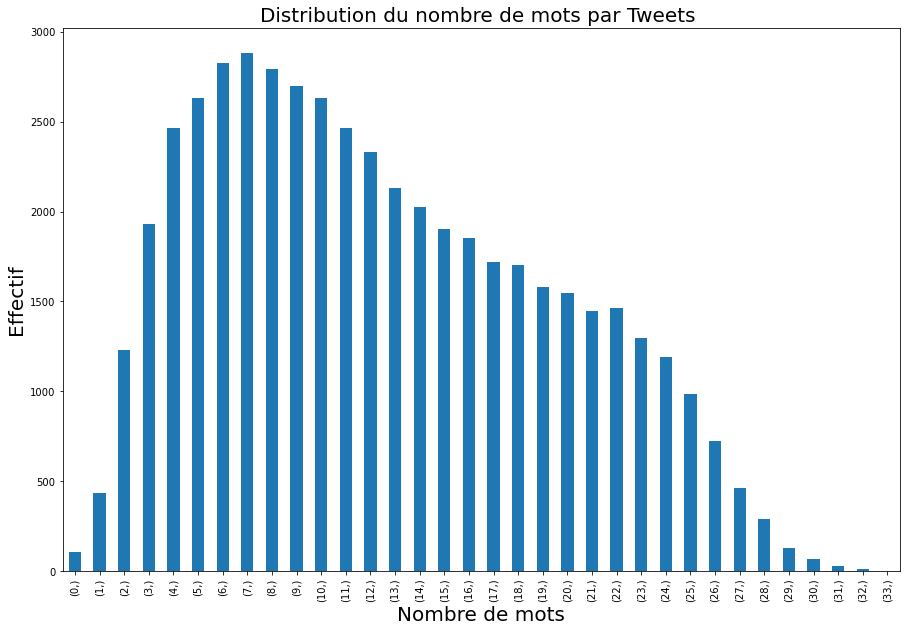

In [156]:
plt.figure(figsize=(15,10))
tweets_length_sorted_df.plot.bar()
plt.xlabel("Nombre de mots", fontsize=20)
plt.ylabel("Effectif", fontsize=20)
plt.title("Distribution du nombre de mots par Tweets ", fontsize=20)
plt.show()

##### Conclusion :
- Au delà de 24 mots, on a une fréquence de moins de 1000 tweets par nombre de mots
> Nous retenons une **longeur maximale de 24 mots**

#### Tokenization
- OOV : 'Out Of Vocabulary'. Le tokenizer va générer un token pour chaquer mot et remplacer chaque mot qu'il ne connait pas par le token 'OOV'
- word_to_index = dictionnaire mot - indice du mot

In [157]:
MAX_WORD_LENGTH = 24
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

In [158]:
tokenizer = Tokenizer(oov_token = oov_tk)
tokenizer.fit_on_texts(X_train_sample)

word_to_index = tokenizer.word_index
vocabulary_size = len(word_to_index) + 1

print("Vocabulary size :", vocabulary_size)

Vocabulary size : 36063


##### Sauvegarde du Tokenizer pour être utilisé lors du déploiement sur Azure

In [159]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [160]:
len(word_to_index)

36062

In [161]:
word_to_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'a': 5,
 'my': 6,
 'and': 7,
 'you': 8,
 'is': 9,
 'it': 10,
 'in': 11,
 'for': 12,
 'of': 13,
 'on': 14,
 'me': 15,
 'so': 16,
 'have': 17,
 'that': 18,
 "i'm": 19,
 'but': 20,
 'just': 21,
 'with': 22,
 'be': 23,
 'at': 24,
 'not': 25,
 'was': 26,
 'this': 27,
 'up': 28,
 'now': 29,
 'good': 30,
 'day': 31,
 'get': 32,
 'out': 33,
 'all': 34,
 'no': 35,
 'are': 36,
 'like': 37,
 'go': 38,
 'your': 39,
 'too': 40,
 'do': 41,
 'today': 42,
 'going': 43,
 'love': 44,
 "it's": 45,
 'work': 46,
 'quot': 47,
 'got': 48,
 'lol': 49,
 'back': 50,
 'from': 51,
 'time': 52,
 'am': 53,
 'one': 54,
 'what': 55,
 'u': 56,
 'know': 57,
 'im': 58,
 'about': 59,
 'will': 60,
 'we': 61,
 "don't": 62,
 'really': 63,
 'had': 64,
 'can': 65,
 'amp': 66,
 'see': 67,
 'some': 68,
 'new': 69,
 "can't": 70,
 'if': 71,
 'its': 72,
 'how': 73,
 'thanks': 74,
 'want': 75,
 'still': 76,
 'think': 77,
 'night': 78,
 'well': 79,
 'as': 80,
 'when': 81,
 'oh': 82,
 'home

#### Création de séquences
- On transforme les jeux de données en séquences
- Dans une séquence, chaque mot est remplacé par son indice dans le dictionnaire (Ex : 2 = i)

In [162]:
X_train_sample_sequences = tokenizer.texts_to_sequences(X_train_sample) 
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_app_sequences = tokenizer.texts_to_sequences(X_app)

In [163]:
X_train_sample

array(['i dont want my mama to go',
       'Out in the city on my way to the nail salon and Jamba Juice',
       'never will take open office from sources . total compile time hrs min.',
       ..., "Thanks for passing on the listing! I'm excited about",
       '- you need to get a new phone then',
       'ugh why not? Billy ray says he does but he never does to me'],
      dtype=object)

In [164]:
X_train_sample_sequences

[[2, 153, 75, 6, 1547, 3, 38],
 [33, 11, 4, 611, 14, 6, 124, 3, 4, 2370, 3694, 7, 8181, 1417],
 [167, 60, 164, 539, 465, 51, 4734, 2119, 6815, 52, 961, 1002],
 [21, 510, 4, 169, 1926, 3058, 13, 69, 653, 40, 120, 10, 9, 114, 1481],
 [92,
  88,
  48,
  3,
  38,
  50,
  3,
  151,
  24,
  16,
  10353,
  3059,
  503,
  8182,
  76,
  220,
  3,
  206,
  1336,
  1069],
 [6816, 58, 14819, 3, 184, 1151, 21, 25, 18, 241, 8, 96, 72, 30],
 [239,
  2,
  110,
  2,
  142,
  257,
  11,
  68,
  13,
  285,
  1683,
  81,
  60,
  8,
  41,
  5,
  5913,
  11,
  3978],
 [186, 208, 74, 12, 8183, 14820],
 [74,
  16,
  86,
  12,
  2285,
  288,
  12,
  201,
  42,
  149,
  71,
  10,
  26,
  5,
  168,
  3251,
  12,
  8,
  3,
  863,
  6,
  3252],
 [16, 86, 663, 3, 41, 27, 255],
 [45,
  5,
  69,
  31,
  7,
  2,
  489,
  23,
  194,
  129,
  19,
  11,
  5,
  112,
  30,
  416,
  111,
  29,
  7,
  2,
  62,
  75,
  27,
  194,
  3,
  362],
 [16, 286, 14821],
 [14822, 1079, 9, 712, 4, 213, 3060, 72, 14823, 696, 3253, 23, 11

##### Version sur tout le jeu d'entrainement et de test pour entrainement du modèle finale sur tout le jeu d'entrainement

In [165]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

##### Version avec tweets non préprocessés et light préprocessés pour comparaison des résulats

In [166]:
X_train_sample_notpreprocessed_sequences = tokenizer.texts_to_sequences(X_train_sample_notpreprocessed)
X_val_notpreprocessed_sequences = tokenizer.texts_to_sequences(X_val_notpreprocessed)

In [167]:
X_train_sample_lightpreprocessed_sequences = tokenizer.texts_to_sequences(X_train_sample_lightpreprocessed)
X_val_lightpreprocessed_sequences = tokenizer.texts_to_sequences(X_val_lightpreprocessed)

##### Remarque :
- Les séquences ont des dimensions différentes : dimension séquence = nombre de mots dans la séquence 

#### Padding des séquences
- Le Padding est utilisé pour gérer des phrases (tweets dans notre cas) avec de longueurs différentes
- Les réseaux de neurones fonctionnent mieux avec des séquences de même dimension
- On va compléter les séquences pour qu'elles aient toutes la même dimension (dimension = max_word_length)

In [168]:
X_train_sample_pad = pad_sequences(X_train_sample_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
X_val_pad = pad_sequences(X_val_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
X_app_pad = pad_sequences(X_app_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)

In [169]:
print("X_train_sample_pad Shape:", X_train_sample_pad.shape)
print("X_val_pad Shape:", X_val_pad.shape)
print("X_app_pad Shape:", X_app_pad.shape)

X_train_sample_pad Shape: (50000, 24)
X_val_pad Shape: (50000, 24)
X_app_pad Shape: (2000, 24)


In [170]:
X_train_sample_pad

array([[   2,  153,   75, ...,    0,    0,    0],
       [  33,   11,    4, ...,    0,    0,    0],
       [ 167,   60,  164, ...,    0,    0,    0],
       ...,
       [  74,   12, 2258, ...,    0,    0,    0],
       [   8,   87,    3, ...,    0,    0,    0],
       [ 278,  109,   25, ...,    0,    0,    0]])

In [171]:
X_train_sample_pad[0]

array([   2,  153,   75,    6, 1547,    3,   38,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [172]:
len(X_train_sample_pad[0])

24

In [173]:
X_train_sample_pad[1]

array([  33,   11,    4,  611,   14,    6,  124,    3,    4, 2370, 3694,
          7, 8181, 1417,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [174]:
len(X_train_sample_pad[1])

24

In [175]:
print("y_train_sample shape:", y_train_sample.shape)
print("y_val shape:", y_val.shape)
print("y_app shape:", y_app.shape)

y_train_sample shape: (50000,)
y_val shape: (50000,)
y_app shape: (2000,)


##### Version sur tout le jeu d'entrainement et de test pour entrainement du modèle finale sur tout le jeu d'entrainement

In [176]:
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)

##### Version avec tweets non préprocessés et light préprocessés pour comparaison des résulats

In [177]:
X_train_sample_notpreprocessed_pad = pad_sequences(X_train_sample_notpreprocessed_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
X_val_notpreprocessed_pad = pad_sequences(X_val_notpreprocessed_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)

In [178]:
X_train_sample_lightpreprocessed_pad = pad_sequences(X_train_sample_lightpreprocessed_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
X_val_lightpreprocessed_pad = pad_sequences(X_val_lightpreprocessed_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)

### Fonction permettant de calculer le temps d'un modèle
- En plus de comparer l'Accuracy entre les différents modèles nous allons également calculer le **temps d'exécution** de chaque modèle afin de choisir le meilleur
- Pour cela nous utilisons la fonction 'Callback' ci-dessous

In [179]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [180]:
time_callback = TimeHistory()

In [181]:
# Hyper paramètres
NUM_EPOCHS = 10
BATCH_SIZE = 128
NUM_NEURONS = 50
EMBEDDING_DIMENSION = 300

### Modélisations utilisant différentes architectures de réseaux de neurones
- Nous allons mettre en place et comparer les différentes architectures de modèles :
    - avec plongements de mots appris par le réseau
    - puis avec plongements de mots fournis au réseau

#### Fonction 'utiliataire' permettant d'afficher l'évolution de l'accuracy en fonction du nombre d'epochs

In [182]:
def plot_accuracy_loss(model_history): 
    plt.figure()
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
    plt.show()

### Words Embedding appris par le réseau

**1. Simple RNN (Recurrent Neural Networks) Model**

In [183]:
simple_RNN_model = Sequential()
simple_RNN_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENSION, input_length=MAX_WORD_LENGTH))
simple_RNN_model.add(SimpleRNN(units=NUM_NEURONS))
simple_RNN_model.add(Dense(units=1, activation='sigmoid'))
simple_RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 300)           10818900  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                17550     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,836,501
Trainable params: 10,836,501
Non-trainable params: 0
_________________________________________________________________


In [184]:
%%time
history_simple_RNN_model = simple_RNN_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 55s 141ms/step - loss: 0.5522 - accuracy: 0.7166 - val_loss: 0.4970 - val_accuracy: 0.7656
Epoch 2/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3486 - accuracy: 0.8530 - val_loss: 0.5763 - val_accuracy: 0.7489
Epoch 3/10
391/391 [==============================] - 56s 144ms/step - loss: 0.1910 - accuracy: 0.9285 - val_loss: 0.6564 - val_accuracy: 0.7453
Epoch 4/10
391/391 [==============================] - 55s 141ms/step - loss: 0.1068 - accuracy: 0.9623 - val_loss: 0.7731 - val_accuracy: 0.7055
Epoch 5/10
391/391 [==============================] - 57s 147ms/step - loss: 0.0721 - accuracy: 0.9759 - val_loss: 0.8614 - val_accuracy: 0.7153
Epoch 6/10
391/391 [==============================] - 61s 155ms/step - loss: 0.0526 - accuracy: 0.9822 - val_loss: 0.9763 - val_accuracy: 0.7092
Epoch 7/10
391/391 [==============================] - 55s 141ms/step - loss: 0.0482 - accuracy: 0.9839 - val_loss: 1.0470 - val_ac

In [185]:
times_simple_RNN_model = time_callback.times

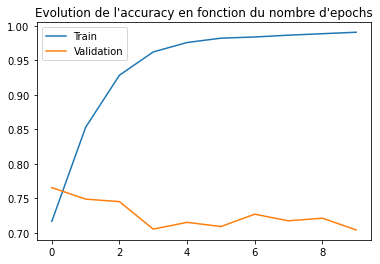

In [186]:
plot_accuracy_loss(history_simple_RNN_model)

**2. Simple LSTM (Long Short Term Memory) Model**

In [187]:
simple_LSTM_model = Sequential()
simple_LSTM_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENSION, input_length=MAX_WORD_LENGTH))
simple_LSTM_model.add(LSTM(units=NUM_NEURONS))
simple_LSTM_model.add(Dense(units=1, activation='sigmoid'))
simple_LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,889,151
Trainable params: 10,889,151
Non-trainable params: 0
_________________________________________________________________


In [188]:
%%time
history_simple_LSTM_model = simple_LSTM_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 65s 166ms/step - loss: 0.5234 - accuracy: 0.7315 - val_loss: 0.4727 - val_accuracy: 0.7744
Epoch 2/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3778 - accuracy: 0.8346 - val_loss: 0.4893 - val_accuracy: 0.7701
Epoch 3/10
391/391 [==============================] - 64s 164ms/step - loss: 0.2870 - accuracy: 0.8795 - val_loss: 0.5566 - val_accuracy: 0.7649
Epoch 4/10
391/391 [==============================] - 63s 162ms/step - loss: 0.2120 - accuracy: 0.9120 - val_loss: 0.6604 - val_accuracy: 0.7555
Epoch 5/10
391/391 [==============================] - 64s 163ms/step - loss: 0.1564 - accuracy: 0.9375 - val_loss: 0.7569 - val_accuracy: 0.7533
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.1195 - accuracy: 0.9518 - val_loss: 0.8258 - val_accuracy: 0.7407
Epoch 7/10
391/391 [==============================] - 63s 162ms/step - loss: 0.0975 - accuracy: 0.9616 - val_loss: 1.0124 - val_ac

In [189]:
times_simple_LSTM_model = time_callback.times

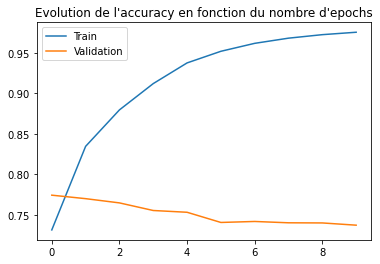

In [190]:
plot_accuracy_loss(history_simple_LSTM_model)

**3. Simple GRU (Gated Recurrent Units) Model**

In [191]:
simple_GRU_model = Sequential()
simple_GRU_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENSION, input_length=MAX_WORD_LENGTH))
simple_GRU_model.add(GRU(units=NUM_NEURONS))
simple_GRU_model.add(Dense(units=1, activation='sigmoid'))
simple_GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
gru (GRU)                    (None, 50)                52800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,871,751
Trainable params: 10,871,751
Non-trainable params: 0
_________________________________________________________________


In [192]:
%%time
history_simple_GRU_model = simple_GRU_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 69s 176ms/step - loss: 0.5623 - accuracy: 0.6816 - val_loss: 0.4712 - val_accuracy: 0.7780
Epoch 2/10
391/391 [==============================] - 62s 158ms/step - loss: 0.3932 - accuracy: 0.8275 - val_loss: 0.4722 - val_accuracy: 0.7773
Epoch 3/10
391/391 [==============================] - 62s 158ms/step - loss: 0.2958 - accuracy: 0.8777 - val_loss: 0.5343 - val_accuracy: 0.7635
Epoch 4/10
391/391 [==============================] - 62s 159ms/step - loss: 0.2171 - accuracy: 0.9133 - val_loss: 0.6412 - val_accuracy: 0.7556
Epoch 5/10
391/391 [==============================] - 63s 160ms/step - loss: 0.1616 - accuracy: 0.9362 - val_loss: 0.7675 - val_accuracy: 0.7471
Epoch 6/10
391/391 [==============================] - 62s 159ms/step - loss: 0.1272 - accuracy: 0.9493 - val_loss: 0.8110 - val_accuracy: 0.7437
Epoch 7/10
391/391 [==============================] - 62s 158ms/step - loss: 0.1032 - accuracy: 0.9592 - val_loss: 0.9761 - val_ac

In [193]:
times_simple_GRU_model = time_callback.times

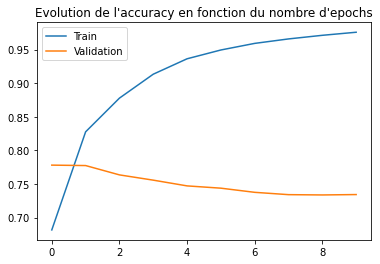

In [194]:
plot_accuracy_loss(history_simple_GRU_model)

**4. Bidirectional LSTM Model**

In [195]:
bidir_LSTM_model = Sequential()
bidir_LSTM_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENSION, input_length=MAX_WORD_LENGTH))
bidir_LSTM_model.add(Bidirectional(LSTM(units=NUM_NEURONS)))
bidir_LSTM_model.add(Dense(units=1, activation='sigmoid'))
bidir_LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
bidir_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               140400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,959,401
Trainable params: 10,959,401
Non-trainable params: 0
_________________________________________________________________


In [196]:
%%time
history_bidir_LSTM_model = bidir_LSTM_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 85s 219ms/step - loss: 0.5173 - accuracy: 0.7418 - val_loss: 0.4684 - val_accuracy: 0.7768
Epoch 2/10
391/391 [==============================] - 91s 234ms/step - loss: 0.3706 - accuracy: 0.8375 - val_loss: 0.4862 - val_accuracy: 0.7748
Epoch 3/10
391/391 [==============================] - 92s 234ms/step - loss: 0.2786 - accuracy: 0.8822 - val_loss: 0.5431 - val_accuracy: 0.7654
Epoch 4/10
391/391 [==============================] - 83s 212ms/step - loss: 0.2088 - accuracy: 0.9134 - val_loss: 0.6716 - val_accuracy: 0.7590
Epoch 5/10
391/391 [==============================] - 87s 223ms/step - loss: 0.1559 - accuracy: 0.9360 - val_loss: 0.8179 - val_accuracy: 0.7532
Epoch 6/10
391/391 [==============================] - 84s 215ms/step - loss: 0.1196 - accuracy: 0.9517 - val_loss: 0.9465 - val_accuracy: 0.7541
Epoch 7/10
391/391 [==============================] - 94s 241ms/step - loss: 0.0926 - accuracy: 0.9632 - val_loss: 1.0478 - val_ac

In [197]:
times_bidir_LSTM_model = time_callback.times

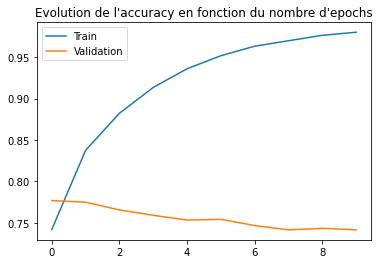

In [198]:
plot_accuracy_loss(history_bidir_LSTM_model)

**5. Bidirectional GRU Model**

In [199]:
bidir_GRU_model = Sequential()
bidir_GRU_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIMENSION, input_length=MAX_WORD_LENGTH))
bidir_GRU_model.add(Bidirectional(GRU(units=NUM_NEURONS)))
bidir_GRU_model.add(Dense(units=1, activation='sigmoid'))
bidir_GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
bidir_GRU_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               105600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 10,924,601
Trainable params: 10,924,601
Non-trainable params: 0
_________________________________________________________________


In [200]:
%%time
history_bidir_GRU_model = bidir_GRU_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 83s 211ms/step - loss: 0.5214 - accuracy: 0.7414 - val_loss: 0.4661 - val_accuracy: 0.7783
Epoch 2/10
391/391 [==============================] - 79s 203ms/step - loss: 0.3701 - accuracy: 0.8376 - val_loss: 0.4795 - val_accuracy: 0.7738
Epoch 3/10
391/391 [==============================] - 71s 182ms/step - loss: 0.2742 - accuracy: 0.8866 - val_loss: 0.5536 - val_accuracy: 0.7603
Epoch 4/10
391/391 [==============================] - 71s 182ms/step - loss: 0.2011 - accuracy: 0.9194 - val_loss: 0.6225 - val_accuracy: 0.7517
Epoch 5/10
391/391 [==============================] - 72s 184ms/step - loss: 0.1484 - accuracy: 0.9411 - val_loss: 0.7396 - val_accuracy: 0.7475
Epoch 6/10
391/391 [==============================] - 74s 190ms/step - loss: 0.1136 - accuracy: 0.9549 - val_loss: 0.8612 - val_accuracy: 0.7424
Epoch 7/10
391/391 [==============================] - 78s 199ms/step - loss: 0.0884 - accuracy: 0.9664 - val_loss: 0.9324 - val_ac

In [201]:
times_bidir_GRU_model = time_callback.times

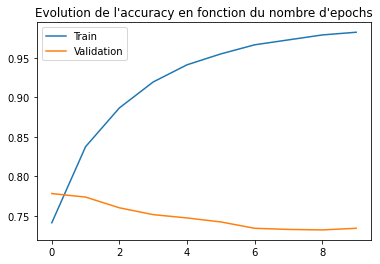

In [202]:
plot_accuracy_loss(history_bidir_GRU_model)

##### Remarque :
- Tous les modèles sont en overfitting

### Words Embedding fourni au réseau

**1. Simple RNN Model**

In [203]:
simple_RNN_embed_model = Sequential()
simple_RNN_embed_model.add(Embedding(vocabulary_size,
                              GLOVE_EMBEDDING_DIMENSION,
                              weights=[glove_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
simple_RNN_embed_model.add(SimpleRNN(units=NUM_NEURONS))
simple_RNN_embed_model.add(Dense(units=1, activation='sigmoid'))
simple_RNN_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_RNN_embed_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,836,501
Trainable params: 17,601
Non-trainable params: 10,818,900
_________________________________________________________________


In [204]:
%%time
history_simple_RNN_embed_model = simple_RNN_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 8s 19ms/step - loss: 0.5895 - accuracy: 0.6882 - val_loss: 0.5593 - val_accuracy: 0.7150
Epoch 2/10
391/391 [==============================] - 8s 19ms/step - loss: 0.5455 - accuracy: 0.7299 - val_loss: 0.5511 - val_accuracy: 0.7217
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.5301 - accuracy: 0.7376 - val_loss: 0.5426 - val_accuracy: 0.7292
Epoch 4/10
391/391 [==============================] - 8s 19ms/step - loss: 0.5199 - accuracy: 0.7461 - val_loss: 0.5433 - val_accuracy: 0.7276
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5112 - accuracy: 0.7485 - val_loss: 0.5330 - val_accuracy: 0.7358
Epoch 6/10
391/391 [==============================] - 8s 20ms/step - loss: 0.4977 - accuracy: 0.7610 - val_loss: 0.5394 - val_accuracy: 0.7316
Epoch 7/10
391/391 [==============================] - 7s 19ms/step - loss: 0.4880 - accuracy: 0.7656 - val_loss: 0.5322 - val_accuracy: 0.7355

In [205]:
times_simple_RNN_embed_model = time_callback.times

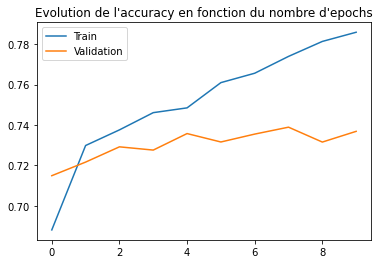

In [206]:
plot_accuracy_loss(history_simple_RNN_embed_model)

**2. Simple LSTM (Long Short Term Memory) Model**

In [207]:
simple_LSTM_embed_model = Sequential()
simple_LSTM_embed_model.add(Embedding(vocabulary_size,
                              GLOVE_EMBEDDING_DIMENSION,
                              weights=[glove_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
simple_LSTM_embed_model.add(LSTM(units=NUM_NEURONS))
simple_LSTM_embed_model.add(Dense(units=1, activation='sigmoid'))
simple_LSTM_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_LSTM_embed_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 10,889,151
Trainable params: 70,251
Non-trainable params: 10,818,900
_________________________________________________________________


In [208]:
%%time
history_simple_LSTM_embed_model = simple_LSTM_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 17s 45ms/step - loss: 0.5504 - accuracy: 0.7130 - val_loss: 0.5154 - val_accuracy: 0.7444
Epoch 2/10
391/391 [==============================] - 16s 42ms/step - loss: 0.4926 - accuracy: 0.7592 - val_loss: 0.4959 - val_accuracy: 0.7592
Epoch 3/10
391/391 [==============================] - 16s 42ms/step - loss: 0.4662 - accuracy: 0.7776 - val_loss: 0.4811 - val_accuracy: 0.7683
Epoch 4/10
391/391 [==============================] - 17s 42ms/step - loss: 0.4495 - accuracy: 0.7869 - val_loss: 0.4720 - val_accuracy: 0.7728
Epoch 5/10
391/391 [==============================] - 17s 42ms/step - loss: 0.4325 - accuracy: 0.7980 - val_loss: 0.4720 - val_accuracy: 0.7753
Epoch 6/10
391/391 [==============================] - 17s 42ms/step - loss: 0.4127 - accuracy: 0.8093 - val_loss: 0.4863 - val_accuracy: 0.7695
Epoch 7/10
391/391 [==============================] - 16s 42ms/step - loss: 0.3965 - accuracy: 0.8199 - val_loss: 0.4861 - val_accuracy:

In [209]:
times_simple_LSTM_embed_model = time_callback.times

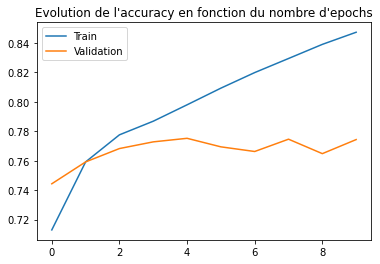

In [210]:
plot_accuracy_loss(history_simple_LSTM_embed_model)

**3. Simple GRU (Gated Recurrent Units) Model**

In [211]:
simple_GRU_embed_model = Sequential()
simple_GRU_embed_model.add(Embedding(vocabulary_size,
                              GLOVE_EMBEDDING_DIMENSION,
                              weights=[glove_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
simple_GRU_embed_model.add(GRU(units=NUM_NEURONS))
simple_GRU_embed_model.add(Dense(units=1, activation='sigmoid'))
simple_GRU_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_GRU_embed_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 10,871,751
Trainable params: 52,851
Non-trainable params: 10,818,900
_________________________________________________________________


In [212]:
%%time
history_simple_GRU_embed_model = simple_GRU_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 16s 40ms/step - loss: 0.5715 - accuracy: 0.6811 - val_loss: 0.5088 - val_accuracy: 0.7477
Epoch 2/10
391/391 [==============================] - 15s 38ms/step - loss: 0.4870 - accuracy: 0.7637 - val_loss: 0.4847 - val_accuracy: 0.7663
Epoch 3/10
391/391 [==============================] - 15s 38ms/step - loss: 0.4605 - accuracy: 0.7822 - val_loss: 0.4703 - val_accuracy: 0.7761
Epoch 4/10
391/391 [==============================] - 15s 38ms/step - loss: 0.4439 - accuracy: 0.7913 - val_loss: 0.4641 - val_accuracy: 0.7799
Epoch 5/10
391/391 [==============================] - 15s 38ms/step - loss: 0.4281 - accuracy: 0.8015 - val_loss: 0.4675 - val_accuracy: 0.7811
Epoch 6/10
391/391 [==============================] - 15s 38ms/step - loss: 0.4090 - accuracy: 0.8123 - val_loss: 0.4667 - val_accuracy: 0.7772
Epoch 7/10
391/391 [==============================] - 15s 38ms/step - loss: 0.3945 - accuracy: 0.8211 - val_loss: 0.4801 - val_accuracy:

In [213]:
times_simple_GRU_embed_model = time_callback.times

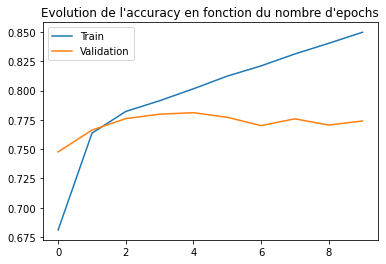

In [214]:
plot_accuracy_loss(history_simple_GRU_embed_model)

**4. Bidirectional LSTM Model**

In [215]:
bidir_LSTM_embed_model = Sequential()
bidir_LSTM_embed_model.add(Embedding(vocabulary_size,
                              GLOVE_EMBEDDING_DIMENSION,
                              weights=[glove_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
bidir_LSTM_embed_model.add(Bidirectional(LSTM(units=NUM_NEURONS)))
bidir_LSTM_embed_model.add(Dense(units=1, activation='sigmoid'))
bidir_LSTM_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
bidir_LSTM_embed_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 10,959,401
Trainable params: 140,501
Non-trainable params: 10,818,900
_________________________________________________________________


In [216]:
%%time
history_bidir_LSTM_embed_model = bidir_LSTM_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 27s 70ms/step - loss: 0.5435 - accuracy: 0.7198 - val_loss: 0.5105 - val_accuracy: 0.7471
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.4844 - accuracy: 0.7655 - val_loss: 0.4895 - val_accuracy: 0.7628
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.4531 - accuracy: 0.7860 - val_loss: 0.4767 - val_accuracy: 0.7700
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4294 - accuracy: 0.8006 - val_loss: 0.4716 - val_accuracy: 0.7742
Epoch 5/10
391/391 [==============================] - 26s 68ms/step - loss: 0.4053 - accuracy: 0.8147 - val_loss: 0.4764 - val_accuracy: 0.7723
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3743 - accuracy: 0.8320 - val_loss: 0.4933 - val_accuracy: 0.7671
Epoch 7/10
391/391 [==============================] - 26s 68ms/step - loss: 0.3488 - accuracy: 0.8454 - val_loss: 0.4948 - val_accuracy:

In [217]:
times_bidir_LSTM_embed_model = time_callback.times

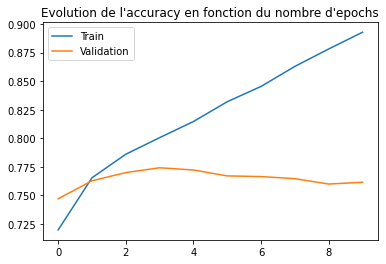

In [218]:
plot_accuracy_loss(history_bidir_LSTM_embed_model)

**5. Bidirectional GRU Model**

In [219]:
bidir_GRU_embed_model = Sequential()
bidir_GRU_embed_model.add(Embedding(vocabulary_size,
                              GLOVE_EMBEDDING_DIMENSION,
                              weights=[glove_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
bidir_GRU_embed_model.add(Bidirectional(GRU(units=NUM_NEURONS)))
bidir_GRU_embed_model.add(Dense(units=1, activation='sigmoid'))
bidir_GRU_embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
bidir_GRU_embed_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 24, 300)           10818900  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               105600    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 10,924,601
Trainable params: 105,701
Non-trainable params: 10,818,900
_________________________________________________________________


In [220]:
%%time
history_bidir_GRU_embed_model = bidir_GRU_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/10
391/391 [==============================] - 25s 64ms/step - loss: 0.5565 - accuracy: 0.7097 - val_loss: 0.5145 - val_accuracy: 0.7453
Epoch 2/10
391/391 [==============================] - 24s 62ms/step - loss: 0.4905 - accuracy: 0.7617 - val_loss: 0.4903 - val_accuracy: 0.7607
Epoch 3/10
391/391 [==============================] - 24s 62ms/step - loss: 0.4632 - accuracy: 0.7783 - val_loss: 0.4803 - val_accuracy: 0.7694
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.4414 - accuracy: 0.7926 - val_loss: 0.4768 - val_accuracy: 0.7713
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.4195 - accuracy: 0.8054 - val_loss: 0.4812 - val_accuracy: 0.7708
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3925 - accuracy: 0.8221 - val_loss: 0.4917 - val_accuracy: 0.7713
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3670 - accuracy: 0.8377 - val_loss: 0.5070 - val_accuracy:

In [221]:
times_bidir_GRU_embed_model = time_callback.times

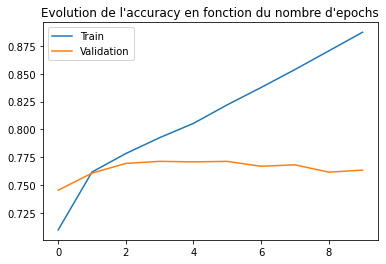

In [222]:
plot_accuracy_loss(history_bidir_GRU_embed_model)

##### Remarques :
- Les résultats en terme d'Accuracy sont légèrement meilleurs pour les modèles avec couche d'embedding fournie au réseau
- Les modèles avec couche d'embedding fournie au réseau permettent de réduire nettement l'overfitting

### Comparaison des modèles et sélection du meilleur modèle
- Nous comparons :
    - l'Accuracy
    - le temps d'exécution

In [223]:
name_history_models = ['simple_RNN_model', 'simple_LSTM_model', 'simple_GRU_model', 'bidir_LSTM_model', 'bidir_GRU_model']
list_history_models = [history_simple_RNN_model, history_simple_LSTM_model, history_simple_GRU_model, history_bidir_LSTM_model, history_bidir_GRU_model]
list_times_models = [times_simple_RNN_model, times_simple_LSTM_model, times_simple_GRU_model, times_bidir_LSTM_model, times_bidir_GRU_model]

name_history_embed_models = ['simple_RNN_embed_model', 'simple_LSTM_embed_model', 'simple_GRU_embed_model', 'bidir_LSTM_embed_model', 'bidir_GRU_embed_model']
list_history_embed_models = [history_simple_RNN_embed_model, history_simple_LSTM_embed_model, history_simple_GRU_embed_model, history_bidir_LSTM_embed_model, history_bidir_GRU_embed_model]
list_times_embed_models = [times_simple_RNN_embed_model, times_simple_LSTM_embed_model, times_simple_GRU_embed_model, times_bidir_LSTM_embed_model, times_bidir_GRU_embed_model]

#### Comparaison des scores d'Accuracy et des temps d'exécution pour les modèles dont les words embeddings sont appris par les réseaux

In [224]:
best_accuracy_per_model = {}
time_per_model = {}
for i, model_history in enumerate(list_history_models):
    best_accuracy_per_model[name_history_models[i]] = max(model_history.history['val_accuracy'])
    time_per_model[name_history_models[i]] = list_times_models[i][np.argmax(model_history.history['val_accuracy'])]

In [225]:
best_accuracy_per_model_sorted = dict(sorted(best_accuracy_per_model.items(), key=lambda item: item[1], reverse=True))

In [226]:
best_accuracy_per_model_sorted

{'bidir_GRU_model': 0.7783200144767761,
 'simple_GRU_model': 0.7779800295829773,
 'bidir_LSTM_model': 0.7768200039863586,
 'simple_LSTM_model': 0.7743800282478333,
 'simple_RNN_model': 0.7656199932098389}

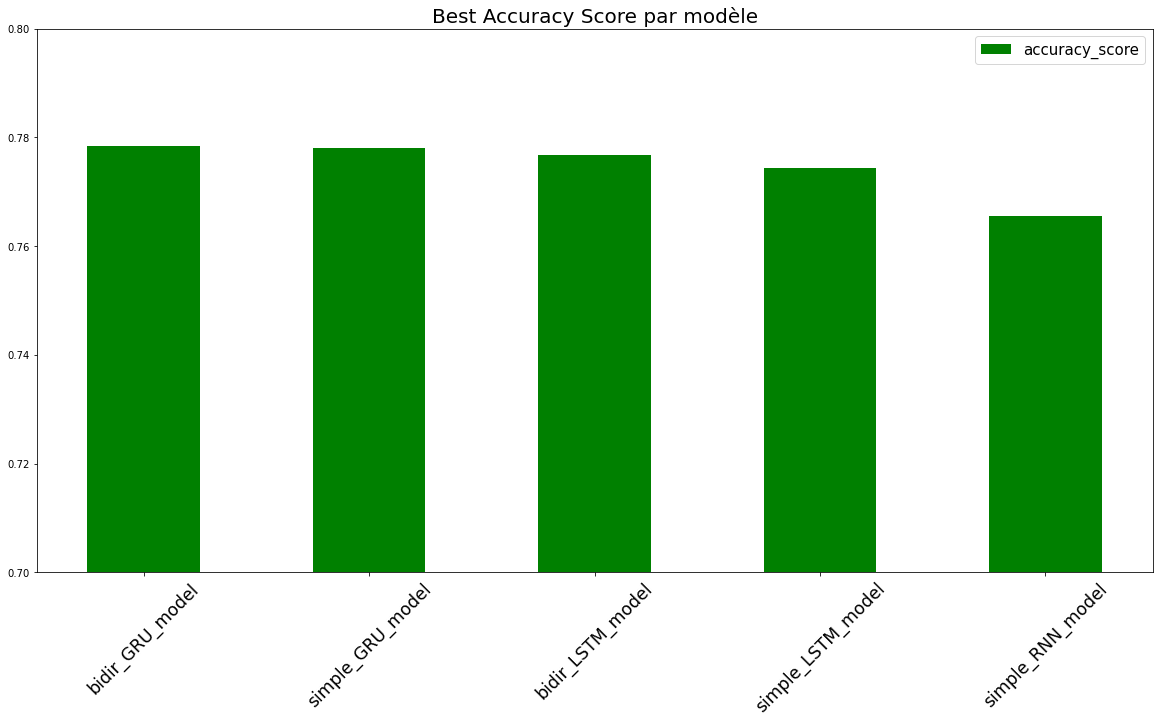

In [227]:
width=0.5
ind=np.arange(len(best_accuracy_per_model_sorted.items()))

plt.figure(figsize=(20,10))
plt.bar(ind, best_accuracy_per_model_sorted.values(), width, color='g', label='accuracy_score')
plt.xticks(range(len(best_accuracy_per_model_sorted.items())), best_accuracy_per_model_sorted.keys(), size='xx-large', rotation=45)
plt.ylim(0.7, 0.8)
plt.legend(fontsize=15)
plt.title("Best Accuracy Score par modèle", fontsize=20)
plt.show()

In [228]:
time_per_model_sorted = dict(sorted(time_per_model.items(), key=lambda item: item[1]))

In [229]:
time_per_model_sorted

{'simple_RNN_model': 56.75806665420532,
 'simple_LSTM_model': 67.84148526191711,
 'simple_GRU_model': 72.61000156402588,
 'bidir_GRU_model': 87.54399704933167,
 'bidir_LSTM_model': 90.40634059906006}

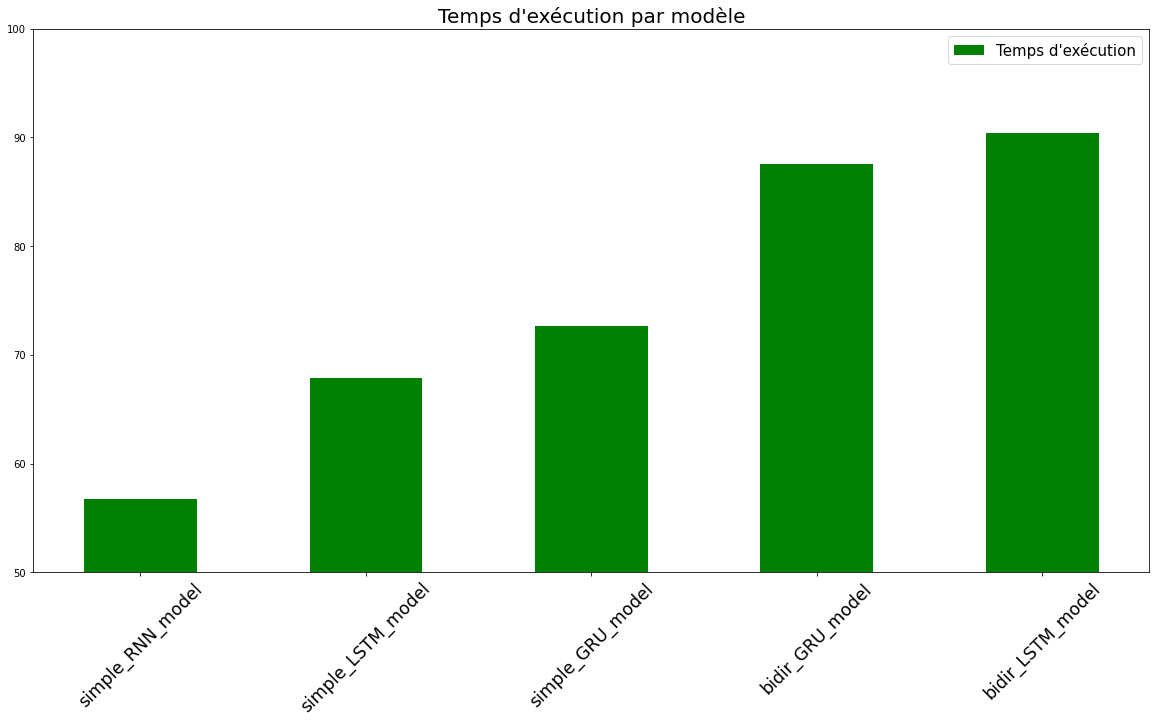

In [230]:
width=0.5
ind=np.arange(len(time_per_model_sorted.items()))

plt.figure(figsize=(20,10))
plt.bar(ind, time_per_model_sorted.values(), width, color='g', label="Temps d'exécution")
plt.xticks(range(len(time_per_model_sorted.items())), time_per_model_sorted.keys(), size='xx-large', rotation=45)
plt.ylim(50, 100)
plt.legend(fontsize=15)
plt.title("Temps d'exécution par modèle", fontsize=20)
plt.show()

#### Comparaison des scores d'Accuracy et des temps d'exécution pour les modèles dont les words embeddings sont fournis aux réseaux

In [231]:
best_accuracy_per_embed_model = {}
time_per_embed_model = {}
for i, model_history in enumerate(list_history_embed_models):
    best_accuracy_per_embed_model[name_history_embed_models[i]] = max(model_history.history['val_accuracy'])
    time_per_embed_model[name_history_embed_models[i]] = list_times_embed_models[i][np.argmax(model_history.history['val_accuracy'])]

In [232]:
best_accuracy_per_embed_model_sorted = dict(sorted(best_accuracy_per_embed_model.items(), key=lambda item: item[1], reverse=True))

In [233]:
best_accuracy_per_embed_model_sorted

{'simple_GRU_embed_model': 0.7811400294303894,
 'simple_LSTM_embed_model': 0.7752599716186523,
 'bidir_LSTM_embed_model': 0.7742000222206116,
 'bidir_GRU_embed_model': 0.7713000178337097,
 'simple_RNN_embed_model': 0.7389400005340576}

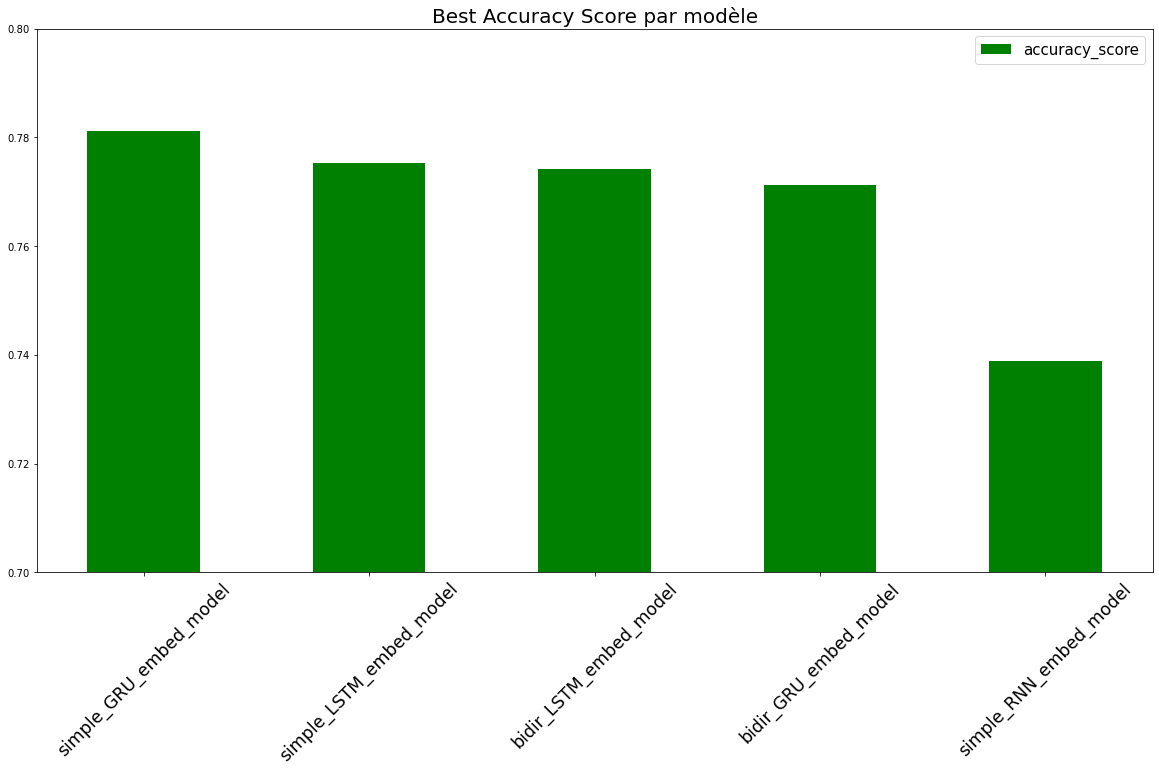

In [234]:
width=0.5
ind=np.arange(len(best_accuracy_per_embed_model_sorted.items()))

plt.figure(figsize=(20,10))
plt.bar(ind, best_accuracy_per_embed_model_sorted.values(), width, color='g', label='accuracy_score')
plt.xticks(range(len(best_accuracy_per_embed_model_sorted.items())), best_accuracy_per_embed_model_sorted.keys(), size='xx-large', rotation=45)
plt.ylim(0.7, 0.8)
plt.legend(fontsize=15)
plt.title("Best Accuracy Score par modèle", fontsize=20)
plt.show()

In [235]:
time_per_embed_model_sorted = dict(sorted(time_per_embed_model.items(), key=lambda item: item[1]))

In [236]:
time_per_embed_model_sorted

{'simple_RNN_embed_model': 7.613997459411621,
 'simple_GRU_embed_model': 14.893011093139648,
 'simple_LSTM_embed_model': 16.53900170326233,
 'bidir_GRU_embed_model': 24.144001722335815,
 'bidir_LSTM_embed_model': 26.560057640075684}

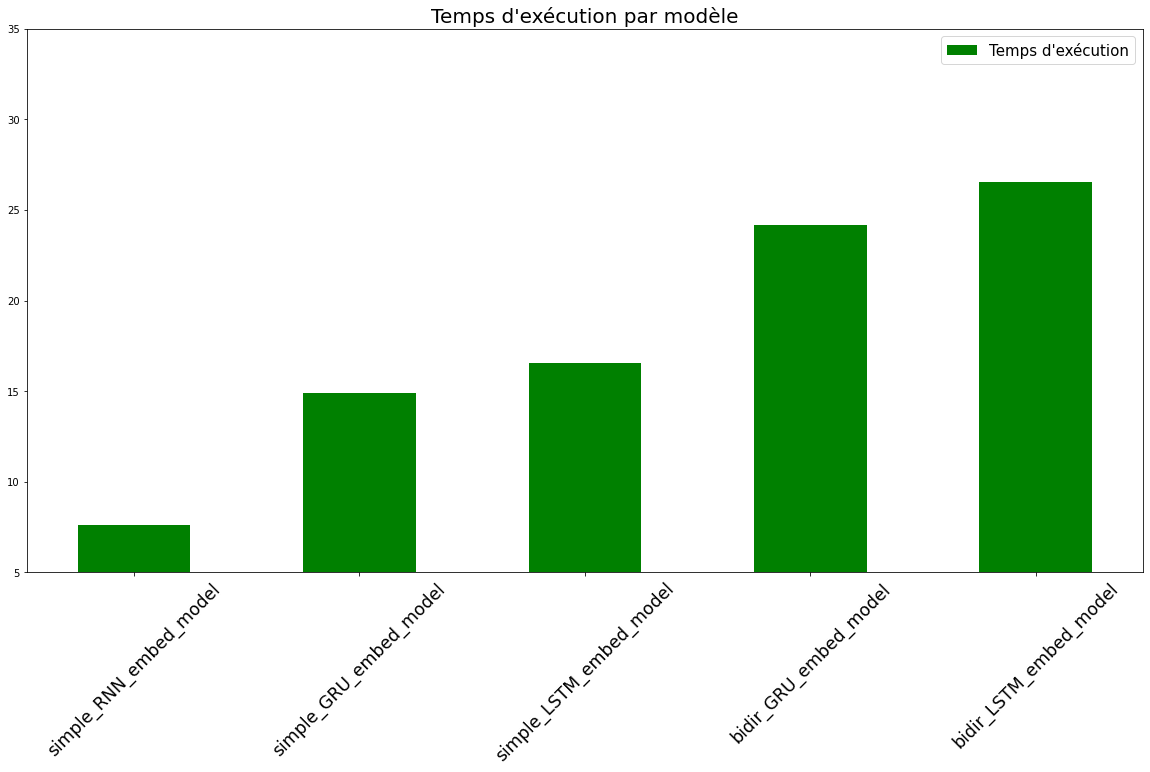

In [237]:
width=0.5
ind=np.arange(len(time_per_model_sorted.items()))

plt.figure(figsize=(20,10))
plt.bar(ind, time_per_embed_model_sorted.values(), width, color='g', label="Temps d'exécution")
plt.xticks(range(len(time_per_embed_model_sorted.items())), time_per_embed_model_sorted.keys(), size='xx-large', rotation=45)
plt.ylim(5, 35)
plt.legend(fontsize=15)
plt.title("Temps d'exécution par modèle", fontsize=20)
plt.show()

#### Conclusion et choix du meilleur modèle :
- Les modèles avec la couche 'words embedding' fournie au réseau présente des résultats meilleurs que ceux dont la couche de 'words embedding' est apprise par le réseau :
    - l'accuracy légèrement meilleurs 
    - ils sont beaucoup plus rapides en terme de temps d'éxécution
    - ils présentent beaucoup moins d'overfitting 
- Parmi ces modèles, c'est le modèle 'simple GRU' qui donne le meilleur résultat en terme d'accuracy
- Le modèle 'simple GRU' est également rapide en temps d'exécution (deuxième plus rapide après le modèle 'simple RNN')
> Le meilleur modèle que nous retenons est le modèle **simple GRU avec couche de plongement de mots fournie au réseau**

### Optimisation du meilleur modèle
- Nous allons optimiser :
    - la couche de 'words embedding' utilisée en essayant deux autres méthodes de plongement de mots :
        - un plongement FastText entrainé sur les Tweets du jeu d'entrainement
        - un plongement de type GloVe mais préentrainé sur des Tweets
    - les hyper paramètres du modèle avec Keras Tuner :
        - optimisation des Dropout
        - optimisation du Learning Rate

### Optimisation du plongement de mots utilisé

### Modèle FastText appris sur les Tweets du jeu d'entrainement

#### Construction de la liste des tweets

In [238]:
tweets_list = [tweet.split() for tweet in tweets]

#### Entrainement du modèle

In [239]:
fasttext_trained_model = FastText(vector_size=10, window=3, min_count=1)

In [240]:
fasttext_trained_model.build_vocab(corpus_iterable=tweets_list)

In [241]:
fasttext_trained_model.train(corpus_iterable=tweets_list, total_examples=len(tweets_list), epochs=10)

(5188548, 6243950)

#### Test du modèle

In [242]:
fasttext_trained_model.wv['good']

array([-4.9762235 , -1.7549758 ,  0.49720538, -1.3267612 ,  5.485787  ,
        0.96414775,  1.9203751 ,  6.924828  ,  3.3974898 , -0.3790657 ],
      dtype=float32)

#### Création de la matrice embedding FastText
- Matrice contenant pour chaque mot du vocabulaire le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [243]:
FASTTEXT_EMBEDDING_DIMENSION = 10

fasttext_embedding_matrix = np.zeros((vocabulary_size, FASTTEXT_EMBEDDING_DIMENSION))

for word, i in word_to_index.items():
        fasttext_embedding_matrix[i] = fasttext_trained_model.wv[word]

#### Taille de la matrice embedding

In [244]:
fasttext_embedding_matrix.shape

(36063, 10)

In [245]:
fasttext_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.33554053e-02,  1.70114897e-02,  2.27545593e-02, ...,
         4.61795442e-02, -2.62097139e-02,  3.10966186e-02],
       [ 5.18938243e-01, -9.23791313e+00,  1.74187107e+01, ...,
        -1.88504016e+00, -1.78041101e+00, -5.08223629e+00],
       ...,
       [ 2.64003843e-01, -1.51170030e-01,  2.29229856e+00, ...,
        -5.05305409e-01,  8.06227922e-01,  1.34108770e+00],
       [-7.86832929e-01,  7.30328858e-01,  7.94112146e-01, ...,
         4.21229362e-01,  1.07532263e+00,  3.34011227e-01],
       [ 1.59941226e-01,  5.43300509e-01,  6.85139060e-01, ...,
         8.09027076e-01, -1.47547364e-01,  3.45010549e-01]])

In [246]:
simple_GRU_fasttext_model = Sequential()
simple_GRU_fasttext_model.add(Embedding(vocabulary_size,
                              FASTTEXT_EMBEDDING_DIMENSION,
                              weights=[fasttext_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
simple_GRU_fasttext_model.add(GRU(units=NUM_NEURONS))
simple_GRU_fasttext_model.add(Dense(units=1, activation='sigmoid'))
simple_GRU_fasttext_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_GRU_fasttext_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 24, 10)            360630    
_________________________________________________________________
gru_4 (GRU)                  (None, 50)                9300      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 369,981
Trainable params: 9,351
Non-trainable params: 360,630
_________________________________________________________________


In [247]:
%%time
history_simple_GRU_fasttext_model = simple_GRU_fasttext_model.fit(X_train_pad, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/10
9675/9675 [==============================] - 158s 16ms/step - loss: 0.5350 - accuracy: 0.7270 - val_loss: 0.5087 - val_accuracy: 0.7449
Epoch 2/10
9675/9675 [==============================] - 147s 15ms/step - loss: 0.4983 - accuracy: 0.7544 - val_loss: 0.4965 - val_accuracy: 0.7550
Epoch 3/10
9675/9675 [==============================] - 149s 15ms/step - loss: 0.4860 - accuracy: 0.7634 - val_loss: 0.4847 - val_accuracy: 0.7608
Epoch 4/10
9675/9675 [==============================] - 150s 15ms/step - loss: 0.4790 - accuracy: 0.7678 - val_loss: 0.4803 - val_accuracy: 0.7647
Epoch 5/10
9675/9675 [==============================] - 157s 16ms/step - loss: 0.4740 - accuracy: 0.7710 - val_loss: 0.4801 - val_accuracy: 0.7650
Epoch 6/10
9675/9675 [==============================] - 148s 15ms/step - loss: 0.4703 - accuracy: 0.7731 - val_loss: 0.4760 - val_accuracy: 0.7692
Epoch 7/10
9675/9675 [==============================] - 148s 15ms/step - loss: 0.4676 - accuracy: 0.7753 - val_loss: 0

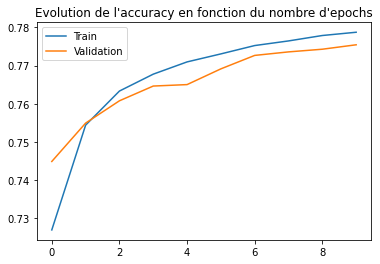

In [248]:
plot_accuracy_loss(history_simple_GRU_fasttext_model)

##### Conclusion :
- Les résultats sont moins bons avec ce modèle comparé au modèle GloVe :
    - l'accuracy est un peu moins élevée (meilleure accuracy = 0.7755 vs 0.7811 pour le modèle GloVe classique)
    - le temps d'exécution de l'entrainement est beaucoup plus long (environ 25 minutes vs moins de 3 minutes pour le modèle GloVe)
- Il y a en revanche peu d'overfitting

### Modèle préentrainé sur des Tweets : GloVe Twitter

#### Chargement du modèle : GloVe word embedding Tweeter 27-billion and 100-dimensional text
- Construction du dictionnaire contenant chaque mot (clé) et son vector embedding (valeur)
- Taille des vecteurs GloVe Twitter = 100

In [249]:
glove_tweeter_embeddings_index = {}

with open('glove.twitter.27B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_tweeter_embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(glove_tweeter_embeddings_index))

Found 1193514 word vectors.


#### Taille du dictionnaire du modèle GloVe

In [250]:
len(glove_tweeter_embeddings_index)

1193514

#### Taille des vecteurs de mots du modèle GloVe

In [251]:
len(glove_tweeter_embeddings_index['good'])

100

#### Exemple de vecteur de mot

In [252]:
glove_tweeter_embeddings_index['good']

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

#### Création de la matrice embedding GloVe Tweeter
- Matrice contenant pour chaque mot du vocabulaire (word_to_index.items()) le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [253]:
GLOVE_TWEETER_EMBEDDING_DIMENSION = 100

glove_tweeter_embedding_matrix = np.zeros((vocabulary_size, GLOVE_TWEETER_EMBEDDING_DIMENSION))

for word, i in word_to_index.items():
        embedding_vector = glove_tweeter_embeddings_index.get(word)
        if embedding_vector is not None:
            glove_tweeter_embedding_matrix[i] = embedding_vector

#### Taille de la matrice embedding

In [254]:
glove_tweeter_embedding_matrix.shape

(36063, 100)

In [255]:
glove_tweeter_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.96210002e-04,  4.56699997e-01,  3.38900000e-01, ...,
        -4.29100007e-01,  1.07459998e+00, -3.65500003e-01],
       ...,
       [ 4.81489986e-01,  3.55300009e-01,  1.21560000e-01, ...,
         1.60870001e-01, -1.04330003e-01, -5.13450027e-01],
       [-5.42729974e-01, -8.41719985e-01, -7.38330007e-01, ...,
         5.82549989e-01, -1.88309997e-01,  4.58189994e-01],
       [ 4.04770002e-02,  2.01890007e-01,  3.04870009e-01, ...,
         1.37060001e-01,  2.08049998e-01, -2.34219998e-01]])

#### Test de la matrice embedding

In [256]:
word_to_index["good"]

30

In [257]:
glove_tweeter_embeddings_index.get("good")

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

In [258]:
simple_GRU_glovetweeter_model = Sequential()
simple_GRU_glovetweeter_model.add(Embedding(vocabulary_size,
                              GLOVE_TWEETER_EMBEDDING_DIMENSION,
                              weights=[glove_tweeter_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
simple_GRU_glovetweeter_model.add(GRU(units=NUM_NEURONS))
simple_GRU_glovetweeter_model.add(Dense(units=1, activation='sigmoid'))
simple_GRU_glovetweeter_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
simple_GRU_glovetweeter_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 24, 100)           3606300   
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 3,629,151
Trainable params: 22,851
Non-trainable params: 3,606,300
_________________________________________________________________


In [259]:
%%time
history_simple_GRU_glovetweeter_model = simple_GRU_glovetweeter_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/10
391/391 [==============================] - 14s 35ms/step - loss: 0.5612 - accuracy: 0.6860 - val_loss: 0.4885 - val_accuracy: 0.7604
Epoch 2/10
391/391 [==============================] - 13s 32ms/step - loss: 0.4710 - accuracy: 0.7750 - val_loss: 0.4708 - val_accuracy: 0.7736
Epoch 3/10
391/391 [==============================] - 13s 33ms/step - loss: 0.4531 - accuracy: 0.7864 - val_loss: 0.4606 - val_accuracy: 0.7805
Epoch 4/10
391/391 [==============================] - 13s 33ms/step - loss: 0.4412 - accuracy: 0.7918 - val_loss: 0.4559 - val_accuracy: 0.7831
Epoch 5/10
391/391 [==============================] - 13s 32ms/step - loss: 0.4322 - accuracy: 0.7983 - val_loss: 0.4532 - val_accuracy: 0.7850
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 0.4209 - accuracy: 0.8064 - val_loss: 0.4527 - val_accuracy: 0.7849
Epoch 7/10
391/391 [==============================] - 13s 33ms/step - loss: 0.4113 - accuracy: 0.8115 - val_loss: 0.4559 - val_accuracy:

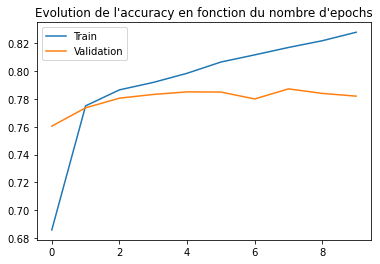

In [260]:
plot_accuracy_loss(history_simple_GRU_glovetweeter_model)

##### Conclusion :
- Les résulats sont meilleurs avec ce plongement de mots GloVe entrainé sur des Tweets comparé au plongement de mots GloVe 'classique' :
    - L'accuracy est légèrement plus élevée (meilleure accuracy = 0.7871 vs 0.7811 pour le modèle GloVe classique)
    - Le temps d'exécution est plus faible (2min 10s vs 2min 34s pour le modèle GloVe classique)
    - L'overfitting a diminué
> Nous sélectionnons donc ce plongement de mots comme couche d'embedding et nous allons optimiser les hyper paramètres du meilleur modèle : **simple GRU avec couche de plongement de mots fournie au réseau de type GloVe préentrainé sur des Tweets**

### Optimisation des hyper paramètres avec KerasTuner

#### Paramètres à optimiser :
- Pourcentage de Dropout : nous avons ajouté 2 couches de type Dropout pour diminuer l'overfitting
- Vitesse d'apprentissage (Learning Rate)                          

In [261]:
def build_simple_GRU_glovetweeter_optim_model(hp):
    
    simple_GRU_glovetweeter_optim_model = Sequential()
    
    simple_GRU_glovetweeter_optim_model.add(Embedding(vocabulary_size,
                              GLOVE_TWEETER_EMBEDDING_DIMENSION,
                              weights=[glove_tweeter_embedding_matrix],
                              input_length=MAX_WORD_LENGTH,
                              trainable=False))
    
    hp_dropout = hp.Float('dropout1', min_value=0, max_value=0.5, step=0.1, default=0.5)
    simple_GRU_glovetweeter_optim_model.add(Dropout(rate=hp_dropout))
    
    simple_GRU_glovetweeter_optim_model.add(GRU(units=NUM_NEURONS))
    
    hp_dropout = hp.Float('dropout2', min_value=0, max_value=0.5, step=0.1, default=0.5)
    simple_GRU_glovetweeter_optim_model.add(Dropout(rate=hp_dropout))
    
    simple_GRU_glovetweeter_optim_model.add(Dense(units=1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    simple_GRU_glovetweeter_optim_model.compile(loss='binary_crossentropy', optimizer=Adam(hp_learning_rate), metrics=['accuracy'])    
    
    simple_GRU_glovetweeter_optim_model.summary()
    
    return simple_GRU_glovetweeter_optim_model

In [262]:
tuner = RandomSearch(
    build_simple_GRU_glovetweeter_optim_model,
    objective="val_accuracy",
    max_trials=10,
    seed=SEED,
    directory='kerasTuner',
    overwrite=True
    #executions_per_trial=3
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 100)           3606300   
_________________________________________________________________
dropout (Dropout)            (None, 24, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,629,151
Trainable params: 22,851
Non-trainable params: 3,606,300
_________________________________________________________________


In [263]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [264]:
tuner.search(X_train_sample_pad, y_train_sample, epochs=10, validation_data=(X_val_pad, y_val))

Trial 10 Complete [00h 04m 25s]
val_accuracy: 0.591159999370575

Best val_accuracy So Far: 0.7872800230979919
Total elapsed time: 00h 44m 05s
INFO:tensorflow:Oracle triggered exit


In [265]:
tuner.results_summary()

Results summary
Results in kerasTuner\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
dropout2: 0.2
learning_rate: 0.001
Score: 0.7872800230979919
Trial summary
Hyperparameters:
dropout1: 0.0
dropout2: 0.0
learning_rate: 0.01
Score: 0.7785000205039978
Trial summary
Hyperparameters:
dropout1: 0.1
dropout2: 0.2
learning_rate: 0.0001
Score: 0.7725200057029724
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
dropout2: 0.1
learning_rate: 0.0001
Score: 0.7687199711799622
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
dropout2: 0.2
learning_rate: 0.0001
Score: 0.7660199999809265
Trial summary
Hyperparameters:
dropout1: 0.4
dropout2: 0.1
learning_rate: 0.0001
Score: 0.7617400288581848
Trial summary
Hyperparameters:
dropout1: 0.2
dropout2: 0.0
learning_rate: 0.1
Score: 0.6792200207710266
Trial summary
Hyperparameters:
dropout1: 0.4
dropout2: 0.1
learning_rate: 0.1
Score

In [266]:
simple_GRU_glovetweeter_best_model = tuner.get_best_models(1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 100)           3606300   
_________________________________________________________________
dropout (Dropout)            (None, 24, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,629,151
Trainable params: 22,851
Non-trainable params: 3,606,300
_________________________________________________________________


In [267]:
simple_GRU_glovetweeter_best_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 24),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 24),
    'dtype': 'float32',
    'input_dim': 36063,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 24}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.30000000000000004,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'GRU',
   'config': {'name': 'gru',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': F

In [268]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [269]:
best_hyperparameters.values

{'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.001}

##### Conclusion :
- Les meilleurs hyper paramètres sont les suivants :
    - Première couche de Dropout = 30%
    - Seconde couche de Dropout = 20%
    - Learning rate = 0.001
- L'optimisation améliore légèrement l'accuracy (meilleure accuracy = 0.7873 vs 0.7871 pour le modèle sans optimisation des hyper paramètres)
- L'optimisation diminue l'overfitting

### Détermination du nombre optimal d'epochs

In [270]:
%%time
history_simple_GRU_glovetweeter_best_model = simple_GRU_glovetweeter_best_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/10
391/391 [==============================] - 14s 36ms/step - loss: 0.4281 - accuracy: 0.7984 - val_loss: 0.4473 - val_accuracy: 0.7889
Epoch 2/10
391/391 [==============================] - 13s 34ms/step - loss: 0.4225 - accuracy: 0.8041 - val_loss: 0.4472 - val_accuracy: 0.7900
Epoch 3/10
391/391 [==============================] - 13s 34ms/step - loss: 0.4249 - accuracy: 0.8023 - val_loss: 0.4524 - val_accuracy: 0.7899
Epoch 4/10
391/391 [==============================] - 13s 34ms/step - loss: 0.4222 - accuracy: 0.8029 - val_loss: 0.4520 - val_accuracy: 0.7894
Epoch 5/10
391/391 [==============================] - 14s 35ms/step - loss: 0.4197 - accuracy: 0.8037 - val_loss: 0.4584 - val_accuracy: 0.7856
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 0.4180 - accuracy: 0.8072 - val_loss: 0.4470 - val_accuracy: 0.7912
Epoch 7/10
391/391 [==============================] - 14s 36ms/step - loss: 0.4159 - accuracy: 0.8097 - val_loss: 0.4473 - val_accuracy:

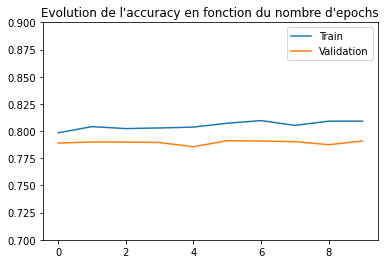

In [271]:
plt.figure()
plt.plot(history_simple_GRU_glovetweeter_best_model.history['accuracy'])
plt.plot(history_simple_GRU_glovetweeter_best_model.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

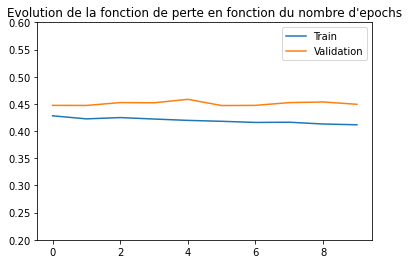

In [272]:
plt.figure()
plt.plot(history_simple_GRU_glovetweeter_best_model.history['loss'])
plt.plot(history_simple_GRU_glovetweeter_best_model.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Evolution de la fonction de perte en fonction du nombre d'epochs")
plt.ylim(0.2, 0.6)
plt.show()

##### Remarque : 
- L'ajout de couches Dropout a fonctionné : l'overfitting a diminué et il est quasi inexistant

In [273]:
val_accuracy_per_epoch = history_simple_GRU_glovetweeter_best_model.history['val_accuracy']

In [274]:
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1

In [275]:
best_epoch

6

### Récapitulatif Meilleur modèle :
- Architecture : simple GRU
- Plongement de mots : GloVe préentrainé sur des Tweets
- Hyper paramètres :
    - Dropout = 30% & 20%
    - Learning rate = 0.001
- Nombre d'epochs : 6
> **Avec ce meilleur modèle on obtient une accuracy de 0.7912**

- Ce modèle de Deep Learning donne une accuracy supérieure à celle du modèle de référence de type Machine Learning (0.791 vs 0.776)

### Comparaison avec les tweets non préprocessés et préprocessés 'léger'

#### Tweets non préprocessés

In [276]:
simple_GRU_glovetweeter_best_model_nopp = simple_GRU_glovetweeter_best_model

In [277]:
%%time
history_simple_GRU_glovetweeter_best_model_nopp = simple_GRU_glovetweeter_best_model_nopp.fit(X_train_sample_notpreprocessed_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=(X_val_notpreprocessed_pad, y_val))

Epoch 1/6
391/391 [==============================] - 15s 38ms/step - loss: 0.4176 - accuracy: 0.8061 - val_loss: 0.4498 - val_accuracy: 0.7893
Epoch 2/6
391/391 [==============================] - 14s 35ms/step - loss: 0.4156 - accuracy: 0.8092 - val_loss: 0.4482 - val_accuracy: 0.7902
Epoch 3/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4117 - accuracy: 0.8095 - val_loss: 0.4603 - val_accuracy: 0.7882
Epoch 4/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4129 - accuracy: 0.8106 - val_loss: 0.4546 - val_accuracy: 0.7883
Epoch 5/6
391/391 [==============================] - 14s 35ms/step - loss: 0.4092 - accuracy: 0.8100 - val_loss: 0.4598 - val_accuracy: 0.7875
Epoch 6/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4080 - accuracy: 0.8119 - val_loss: 0.4536 - val_accuracy: 0.7900
Wall time: 1min 22s


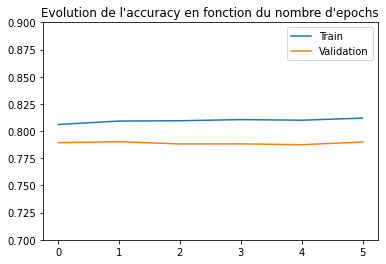

In [278]:
plt.figure()
plt.plot(history_simple_GRU_glovetweeter_best_model_nopp.history['accuracy'])
plt.plot(history_simple_GRU_glovetweeter_best_model_nopp.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

##### Conclusion :
- Les résultats sont moins bons : 
    - l'accuracy est un peu moins élevée (0.7900 vs 0.7912 pour le modèle avec Tweets préprocessés)
    - il y a légèrement plus d'overfitting avec le modèle Tweets non préprocessés

#### Tweets préprocessés de façon 'légère'

In [279]:
simple_GRU_glovetweeter_best_model_lightpp = simple_GRU_glovetweeter_best_model

In [280]:
%%time
history_simple_GRU_glovetweeter_best_model_lightpp = simple_GRU_glovetweeter_best_model.fit(X_train_sample_lightpreprocessed_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=(X_val_lightpreprocessed_pad, y_val))

Epoch 1/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4078 - accuracy: 0.8136 - val_loss: 0.4497 - val_accuracy: 0.7908
Epoch 2/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4053 - accuracy: 0.8131 - val_loss: 0.4497 - val_accuracy: 0.7905
Epoch 3/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4058 - accuracy: 0.8141 - val_loss: 0.4566 - val_accuracy: 0.7903
Epoch 4/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4040 - accuracy: 0.8133 - val_loss: 0.4576 - val_accuracy: 0.7877
Epoch 5/6
391/391 [==============================] - 13s 34ms/step - loss: 0.4014 - accuracy: 0.8168 - val_loss: 0.4619 - val_accuracy: 0.7860
Epoch 6/6
391/391 [==============================] - 13s 34ms/step - loss: 0.3992 - accuracy: 0.8165 - val_loss: 0.4522 - val_accuracy: 0.7894
Wall time: 1min 19s


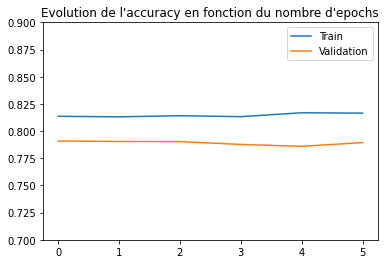

In [281]:
plt.figure()
plt.plot(history_simple_GRU_glovetweeter_best_model_lightpp.history['accuracy'])
plt.plot(history_simple_GRU_glovetweeter_best_model_lightpp.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

##### Conclusion :
- Les résultats sont moins bons : 
    - l'accuracy est un peu moins élevée (0.7894 vs 0.7912 pour le modèle avec Tweets préprocessés de façon complète)
    - il y a légèrement plus d'overfitting avec le modèle Tweets préprocessés de façon légère

#### Conclusion pour le PreProcessing :
- Le preprocessing des Tweets retenu permet d'améliorer le résultat (accuracy plus élevée et moins d'overfitting)

### Evaluation du meilleur modèle optimisé

#### Entrainement du meilleur modèle optimisé sur tout le jeu d'entrainement

In [282]:
%%time
history_simple_GRU_glovetweeter_best_model = simple_GRU_glovetweeter_best_model.fit(X_train_pad, y_train, batch_size=BATCH_SIZE, epochs=best_epoch, callbacks=time_callback)

Epoch 1/6
9675/9675 [==============================] - 220s 23ms/step - loss: 0.4521 - accuracy: 0.7859
Epoch 2/6
9675/9675 [==============================] - 220s 23ms/step - loss: 0.4419 - accuracy: 0.7929
Epoch 3/6
9675/9675 [==============================] - 221s 23ms/step - loss: 0.4377 - accuracy: 0.7953
Epoch 4/6
9675/9675 [==============================] - 227s 23ms/step - loss: 0.4347 - accuracy: 0.7971
Epoch 5/6
9675/9675 [==============================] - 222s 23ms/step - loss: 0.4325 - accuracy: 0.7982
Epoch 6/6
9675/9675 [==============================] - 221s 23ms/step - loss: 0.4315 - accuracy: 0.7989
Wall time: 22min 11s


#### Evaluation du meilleur modèle optimisé sur le jeu de test

In [283]:
simple_GRU_glovetweeter_best_model_accuracy = simple_GRU_glovetweeter_best_model.evaluate(X_test_pad, y_test)

9675/9675 [==============================] - 42s 4ms/step - loss: 0.4101 - accuracy: 0.8115


In [284]:
print(f"Accuracy score = {simple_GRU_glovetweeter_best_model_accuracy[1]:.3f}")

Accuracy score = 0.811


In [285]:
y_pred = simple_GRU_glovetweeter_best_model.predict(X_test_pad)

In [286]:
y_pred

array([[0.05379862],
       [0.5923912 ],
       [0.3458609 ],
       ...,
       [0.01265302],
       [0.4246772 ],
       [0.03673172]], dtype=float32)

In [287]:
y_pred_classes = np.where(y_pred>0.5, 1, 0)

In [288]:
y_pred_classes

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

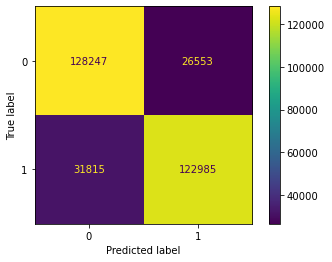

In [289]:
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [290]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81    154800
           1       0.82      0.79      0.81    154800

    accuracy                           0.81    309600
   macro avg       0.81      0.81      0.81    309600
weighted avg       0.81      0.81      0.81    309600



#### Conclusion :
- Sur tout le jeu d'entrainement on obtient une accuracy de **0.811**

### Sauvegarde du meilleur modèle (Format h5)

In [291]:
simple_GRU_glovetweeter_best_model.save('airparadis_best_model.h5')

### Prédictions sur le jeu de données 'app' pour comparaison avec les autres approches

In [292]:
simple_GRU_glovetweeter_best_model_app_accuracy = simple_GRU_glovetweeter_best_model.evaluate(X_app_pad, y_app)

63/63 [==============================] - 0s 4ms/step - loss: 0.4103 - accuracy: 0.8220


#### Accuracy

In [293]:
print(f"Accuracy score = {simple_GRU_glovetweeter_best_model_app_accuracy[1]:.3f}")

Accuracy score = 0.822


#### Matrice de confusion

In [294]:
y_pred_app = simple_GRU_glovetweeter_best_model.predict(X_app_pad)

In [295]:
y_pred_app_classes = np.where(y_pred_app>0.5, 1, 0)

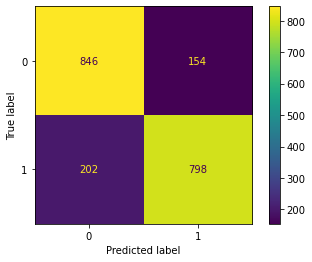

In [296]:
cm = confusion_matrix(y_app, y_pred_app_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

#### Rapport de classification

In [297]:
print(classification_report(y_app, y_pred_app_classes))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.84      0.80      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



#### Conclusion :
- Sur tout le jeu le jeu de données 'app' pour comparaison avec les autres approches on obtient une accuracy de **0.822**

### Analyse des erreurs de prédiction
- Dans cette partie, nous allons essayer de comprendre d'où viennent les erreurs de prédiction

In [298]:
df_app['PREDICTED SENTIMENT'] = y_pred_app_classes
df_app['SCORE'] = y_pred_app

In [299]:
df_app

,SENTIMENT,TWEET,TWEET_PREPROCESSED,PREDICTED SENTIMENT,SCORE
0,1,Pictures!!,Pictures!!,1,0.879773
1,1,just watched One Tree Hill episode 22 season 6...,just watched One Tree Hill episode season ... ...,0,0.408272
2,1,and so the micro blogging begins!!,and so the micro blogging begins!!,1,0.861627
3,1,awesooome. i found me some chickeeen waaangs t...,awesooome. i found me some chickeeen waaangs t...,1,0.689417
4,0,Please don't go.,Please don't go.,0,0.360450
...,...,...,...,...,...
1995,1,Rain wont stop.... bring on the munchies and t...,Rain wont stop.... bring on the munchies and t...,1,0.513786
1996,1,@citylivinggirl Thank you,Thank you,1,0.989353
1997,1,tonight was fun,tonight was fun,1,0.963458
1998,0,Back from #phish. The only downer was leaving ...,Back from . The only downer was leaving and se...,0,0.122630


In [300]:
df_app_error = df_app[df_app['PREDICTED SENTIMENT']!=df_app['SENTIMENT']]

In [301]:
df_app_error = df_app_error.reset_index(drop=True)

In [302]:
df_app_error

,SENTIMENT,TWEET,TWEET_PREPROCESSED,PREDICTED SENTIMENT,SCORE
0,1,just watched One Tree Hill episode 22 season 6...,just watched One Tree Hill episode season ... ...,0,0.408272
1,1,leavin for Houston with the lady tomorrow,leavin for Houston with the lady tomorrow,0,0.467064
2,0,@TheComputerNerd seriously?!?!?!?! i loved hi...,seriously?!?!?!?! i loved his long hair,1,0.807667
3,1,@mcraddictal luckily most of the kids in my ye...,luckily most of the kids in my year are too ol...,0,0.177714
4,0,"@thewaterox thanks! that is, if I ever get be...","thanks! that is, if I ever get beyond having t...",1,0.860987
...,...,...,...,...,...
351,0,@LsRccrd sizemore and betancourt to the dl tod...,sizemore and betancourt to the dl today!,1,0.589023
352,1,"@Moonshayde Manchester! It's getting busy now,...","Manchester! It's getting busy now, well busy i...",0,0.313066
353,1,I think I've never been *this* active on Twitt...,I think I've never been *this* active on Twitt...,0,0.350068
354,1,Off school for the day... although my foots pi...,Off school for the day... although my foots pi...,0,0.337288


In [303]:
def error_analysis(i):
    tweet = df_app_error.loc[i]["TWEET"]
    tweet_preprocessed = df_app_error.loc[i]["TWEET_PREPROCESSED"]
    sentiment_label = df_app_error.loc[i]["SENTIMENT"]
    sentiment_predicted = df_app_error.loc[i]["PREDICTED SENTIMENT"]
    score = df_app_error.loc[i]["SCORE"]

    print(f"Tweet : {tweet}")
    print(f"Tweet preprocessed : {tweet_preprocessed}")
    print(f"Sentiment label : {sentiment_label}")
    print(f"Sentiment predicted : {sentiment_predicted}")
    print(f"Score : {score}")

#### Analyse des 10 premiers Tweets

In [304]:
error_analysis(0)

Tweet : just watched One Tree Hill episode 22 season 6... never cried this much since keith died!!!!!! OTH is epic for sure!!!!!!  Xxx
Tweet preprocessed : just watched One Tree Hill episode season ... never cried this much since keith died!!!!!! OTH is epic for sure!!!!!! Xxx
Sentiment label : 1
Sentiment predicted : 0
Score : 0.4082724452018738


##### Analyse de l'erreur :
- Il est difficile de dire si le sentiment est positif ou négatif : la personne semble à la fois triste car elle a pleuré (sentiment négatif) et à la foix contente car la série est épique (sentiment positif)
- Cette ambiguité se retrouve dans le score proche de 0.5

In [305]:
error_analysis(1)

Tweet : leavin for Houston with the lady tomorrow 
Tweet preprocessed : leavin for Houston with the lady tomorrow
Sentiment label : 1
Sentiment predicted : 0
Score : 0.46706414222717285


##### Analyse de l'erreur :
- Le sentiment n'est ni positif ni négatif, on ne peut pas trancher
- Cela se retrouve dans le score proche de 0.5

In [306]:
error_analysis(2)

Tweet : @TheComputerNerd  seriously?!?!?!?! i loved his long hair 
Tweet preprocessed : seriously?!?!?!?! i loved his long hair
Sentiment label : 0
Sentiment predicted : 1
Score : 0.8076673150062561


##### Analyse de l'erreur :
- Le sentiment est plutôt positif car la personne dit qu'elle a aimé ses longs cheveux
- La prédiction semble donc correcte et c'est le label qui semble erroné

In [307]:
error_analysis(3)

Tweet : @mcraddictal luckily most of the kids in my year are too old for Twilight too  I'm the only MCR fan in my year though D:
Tweet preprocessed : luckily most of the kids in my year are too old for Twilight too I'm the only MCR fan in my year though D:
Sentiment label : 1
Sentiment predicted : 0
Score : 0.17771390080451965


##### Analyse de l'erreur :
- La personne semble contente, on peut donc penser que le sentiment est positif et qu'il s'agit donc d'une erreur de prédiction du modèle

In [308]:
error_analysis(4)

Tweet : @thewaterox thanks!  that is, if I ever get beyond having to defend my decision not to use Marxist Feminism 
Tweet preprocessed : thanks! that is, if I ever get beyond having to defend my decision not to use Marxist Feminism
Sentiment label : 0
Sentiment predicted : 1
Score : 0.8609874248504639


##### Analyse de l'erreur :
- Le sentiment est plutôt positif car la personne remercie et semble donc contente
- La prédiction semble donc correcte et on a affaire à un label erroné

In [309]:
error_analysis(5)

Tweet : Home from work, just ate some cold pizza  Now changing into something more summery... somerfield uniform is meh!
Tweet preprocessed : Home from work, just ate some cold pizza Now changing into something more summery... somerfield uniform is meh!
Sentiment label : 1
Sentiment predicted : 0
Score : 0.20879313349723816


##### Analyse de l'erreur :
- Il est difficile de dire si le sentiment global est positif ou négatif

In [310]:
error_analysis(6)

Tweet : @Karen_M_ TY So glad you liked it. I ate it tonight been awhile. I have a tendency to waste bean sprouts it's  I will make it more often.
Tweet preprocessed : TY So glad you liked it. I ate it tonight been awhile. I have a tendency to waste bean sprouts it's I will make it more often.
Sentiment label : 0
Sentiment predicted : 1
Score : 0.7182848453521729


##### Analyse de l'erreur :
- Le sentiment est positif :  la personne est contente que cela plaise à son interlocuteur
- La prédiction semble donc correcte et on a affaire à un label erroné

In [311]:
error_analysis(7)

Tweet : Alex how could you?!? 
Tweet preprocessed : Alex how could you?!?
Sentiment label : 0
Sentiment predicted : 1
Score : 0.8516227006912231


##### Analyse de l'erreur :
- Il est difficile de dire si le sentiment est positif ou négatif

In [312]:
error_analysis(8)

Tweet : @mrlineup just finished cleaning @alBabyLineup butt his kaka was the color of the incredible HULK! 
Tweet preprocessed : just finished cleaning butt his kaka was the color of the incredible HULK!
Sentiment label : 0
Sentiment predicted : 1
Score : 0.7866607308387756


##### Analyse de l'erreur :
- Il est difficile de dire si le sentiment est positif ou négatif

In [313]:
error_analysis(9)

Tweet : Or maybe it's the other way around. Europeans showing me how to party 
Tweet preprocessed : Or maybe it's the other way around. Europeans showing me how to party
Sentiment label : 0
Sentiment predicted : 1
Score : 0.6986925601959229


##### Analyse de l'erreur :
- Il est difficile de dire si le sentiment est positif ou négatif

#### Conclusion de l'analyse des erreurs :
- Parmi les 10 erreurs analysées :
    - 6 sont liées à une ambiguité au niveau des Tweets :
        - soit le Tweet est ambigu (impossibilité de trancher si le sentiment est positif ou négatif)
        - soit le Tweet comporte à la fois un sentiment positif et un sentiment négatif
    - 3 sont liées à une erreur de labellisation
    - 1 est liée à une erreur du modèle


- Sur les 10 exemples d' 'erreurs' analysées, 1 seule erreur semble provenir du modèle
- L'analyse des erreurs nous montre que sur cet échantillon seulement 1% des erreurs provient du modèle
- La grand majorité des 'erreurs' ne semble pas provenir du modèle, ce qui peut expliquer pourquoi il est difficile de dépasser 80% d'accuracy

# Prototype permettant de prédire le sentiment associé à un tweet
- Ce prototype permet de prédire le sentiment associé à un tweet en utilisant le modèle 'local', c'est à dire le modèle se trouvant dans ce Notebook
- Une version 'remote', c'est à dire un prototype permettant d'interroger le modèle déployé dans Azure, se trouve dans le Notebook dédié au déploiement dans Azure 

## Fonction 'prototype' :
- prend en argument un Tweet
- renvoie la prédiction du sentiment et le score de probabilité associé au Tweet en entrée

In [314]:
def get_sentiment(tweet):
    tweet_clean = tweetpreprocessor.clean(tweet)
    tweet_clean_sequence = tokenizer.texts_to_sequences([tweet_clean])
    tweet_clean_pad = pad_sequences(tweet_clean_sequence, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type)
    y_pred = simple_GRU_glovetweeter_best_model.predict(tweet_clean_pad)
    y_pred_classe = np.where(y_pred>0.5, "positive", "negative")
    return f"Sentiment is : {y_pred_classe} - score = {y_pred}"

## Test du déploiement dans Azure
- Test sur 3 Tweets pour vérifier le bon fonctionnement du déploiement dans Azure 

##### Tweet positif

In [315]:
get_sentiment("The service at AirParadis is good")

"Sentiment is : [['positive']] - score = [[0.9623542]]"

##### Tweet négatif

In [316]:
get_sentiment("The service at AirParadis is bad")

"Sentiment is : [['negative']] - score = [[0.03483599]]"

##### Tweet neutre

In [317]:
get_sentiment("The service at AirParadis is average")

"Sentiment is : [['negative']] - score = [[0.47108507]]"